## Install Dependencies

In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.6.0.163-1+cuda11.8
!pip uninstall -y tensorflow estimator keras
!pip install -U tensorflow_text tensorflow tensorflow_datasets
!pip install einops
!pip install optuna
!pip install -U kaleido

## Imports

In [72]:
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import time
import pathlib
import platform
import random
import re
import string
import time
import urllib.request
from typing import List, Tuple, Dict, Union, Any, Callable, Optional

import einops
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import numpy as np
import pandas as pd
from PIL import Image
import IPython.display as display
import requests
import tqdm
import optuna

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

In [2]:
print('Tensorflow version:', tf.__version__)
print('Python version:', platform.python_version())

Tensorflow version: 2.13.0
Python version: 3.10.12


## Data Processing

We use the `Flickr8k` dataset, which is a benchmark collection for sentence-based image description and search, consisting of 8,000 images that are each paired with five different captions which provide clear descriptions of the salient entities and events. The data processing workflow includes the following steps for the image and text data:

* We will use an image model (pretrained on imagenet) to extract features from each image. The model was trained as an image classifier, but we set `include_top=False` to return the convolutional base without the final classification layer.

* We will transform the text captions into integer sequences using the `TextVectorization` layer.

The result of all the processing steps are tf.data.Datasets containing (images, captions) pairs.

### Helpers for Data Processing

In [3]:
def download_flickr8k(path: str = 'flickr8k') -> Tuple[tf.data.Dataset, tf.data.Dataset]:
    """
    Downloads and processes the Flickr8k dataset.

    Parameters
    ----------
    path : str, optional
        The local directory path where the dataset will be downloaded, by default 'flickr8k'.

    Returns
    -------
    Tuple[tf.data.Dataset, tf.data.Dataset]
        A tuple of two tf.data.Dataset objects. The first is the training dataset and the second is the test dataset.
        Each dataset is composed of tuples (image_path, list_of_captions).
    """
    path = pathlib.Path(path)

    # If the number of files in all subdirectories of 'path' is less than 16197
    if len(list(path.rglob('*'))) < 16197:

      # Download zip files
      tf.keras.utils.get_file(
          origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
          cache_dir='.',
          cache_subdir=path,
          extract=True
        )
      tf.keras.utils.get_file(
          origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
          cache_dir='.',
          cache_subdir=path,
          extract=True
        )

    # Read in and process captions
    captions = (path/'Flickr8k.token.txt').read_text().splitlines()
    # List of lists, where the list elements are the tokens seperated by '\t'
    captions = (line.split('\t') for line in captions)
    # list of tuples, where the elements within the tuple are the processed filename and the associated caption
    captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

    # Place captions with the same file name in a list belonging to the same 'key'
    cap_dict = collections.defaultdict(list)
    for fname, cap in captions:
      cap_dict[fname].append(cap)

    # Create a list of tuples (image_path, list_of_captions)
    train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
    train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

    test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
    test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

    # Create datasets from list of (tf.tensor(image_path), tf.tensor(list_of_captions)) tuples
    train_ds = tf.data.experimental.from_list(train_captions)
    test_ds = tf.data.experimental.from_list(test_captions)

    return train_ds, test_ds

In [4]:
def load_image(image_path: str, image_size: Tuple[int, int, int]) -> tf.Tensor:
    """
    This function loads in a single image and resizes it in order to feat the image into the feature extractor
    pre-trianed model.

    Parameters
    ----------
    image_path: str
        The image path.
    image_size: Tuple[int, int, int]
        The input size of the image that the pretrained model expects, to which we have to resize the original image.

    Returns
    -------
    tf.Tensor
        The returned object is an eagar tensor.
    """
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size[:-1])
    return img

In [5]:
def standardize(caption: Union[str, tf.Tensor]) -> tf.Tensor:
    """
    Standardizes the given caption (string or tensor containing a string) by transforming to lower case, removing punctuation, and
    adding '[START]' and '[END]' tokens at the beginning and end of the string, respectively. The output is a tensor
    containing the standardized string.

    Parameters
    ----------
    caption : Union[str, tf.Tensor]
        The input string or tensor containing a string to be standardized.

    Returns
    -------
    tf.Tensor
        A tensor containing the standardized string.
    """
    caption = tf.strings.lower(caption)
    caption = tf.strings.regex_replace(caption, f'[{re.escape(string.punctuation)}]', '')
    caption = tf.strings.join(['[START]', caption, '[END]'], separator=' ')
    return caption

In [6]:
def match_shapes(images: Union[tf.Tensor, tf.RaggedTensor], captions: Union[tf.Tensor, tf.RaggedTensor]) -> Tuple[Union[tf.Tensor, tf.RaggedTensor], Union[tf.Tensor, tf.RaggedTensor]]:
    """
    Function to match the shapes of images and captions tensors.

    It does so by rearranging the captions tensor from shape (b, c) to (b*c) and repeating the images tensor 'c' times
    along a new dimension. The new shape of images will be (b*c, ...).

    Parameters
    ----------
    image_paths : Union[tf.Tensor, tf.RaggedTensor]
        Tensor of images with any shape.
    captions : Union[tf.Tensor, tf.RaggedTensor]
        Tensor of captions with shape (b, c).

    Returns
    -------
    Tuple[Union[tf.Tensor, tf.RaggedTensor], Union[tf.Tensor, tf.RaggedTensor]]
        A tuple of tensors (images, captions), both reshaped to have the same first dimension.
    """
    # Get a dictionary of {'b': batch_size, 'c': num_of_captions}
    caption_shape = einops.parse_shape(captions, 'b c')
    # This reshapes captions fomr a tensor with shape (b, c) to (b*c)
    captions = einops.rearrange(captions, 'b c -> (b c)')
    # Repeat the images tensor for each caption in the batch
    images = einops.repeat(
        images, 'b ... -> (b c) ...',
        c = caption_shape['c']
    )
    return images, captions


In [7]:
def prepare_txt(images: Union[tf.Tensor, tf.RaggedTensor],
                texts: Union[tf.Tensor, tf.RaggedTensor, list[str]]) -> Tuple[Tuple[tf.Tensor, tf.RaggedTensor], tf.RaggedTensor]:
    """
    This function tokenizes the text data and prepares it for use with Keras. The training dataset should contain
    (inputs, labels) pairs. For caption generation, the tokens are both inputs and labels, shifted by one step. In
    other words, for each step, given the previously generated tokens, we wish to generate the next token. This
    function will convert an (tf.tensor(images), tf.tensor(texts)) pair to an ((images, input_tokens), label_tokens)
    pair.

    The function first tokenizes the input texts, then creates two new tensors:

    - input_tokens, which includes all but the last token in each sequence
    - label_tokens, which includes all but the first token in each sequence

    This is a common preparation step for sequence-to-sequence models, where the model is trained to predict each token
    in the sequence given all the previous tokens.

    Parameters
    ----------
    images : Union[tf.Tensor, tf.RaggedTensor]
        Tensor of images with any shape.
    texts : Union[tf.Tensor, tf.RaggedTensor, list[str]]
        Tensor or list of texts to be tokenized.

    Returns
    -------
    Tuple[Tuple[tf.Tensor, tf.RaggedTensor], tf.RaggedTensor]
        A tuple where the first element is another tuple containing the images and the input tokens tensor,
        and the second element is the label tokens tensor.
    """
    tokens = tokenizer(texts)
    # Subset for all but the last token
    input_tokens = tokens[..., :-1]
    # Subset for all but the first token
    label_tokens = tokens[..., 1:]
    return (images, input_tokens), label_tokens


In [8]:
def prepare_dataset(ds: tf.data.Dataset,
                    tokenizer: Callable,
                    image_size: Tuple[int, int],
                    batch_size: Optional[int] = 32,
                    shuffle_buffer: Optional[int] = 1000) -> tf.data.Dataset:
    """
    This function prepares a dataset for use in model training. The function applies several transformations to
    the dataset one at a time:

    - Shuffles the dataset.
    - Loads the images, then resizes and batches them.
    - Matches the shapes of the images and captions so each pair of examples is 1:1.
    - Unbatches the dataset, shuffles the dataset again, and then batches the dataset again.
    - Prepares the text by tokenizing and splitting the texts into input and label tokens.
    - Converts the input and label tokens to tensors.

    Parameters
    ----------
    ds : tf.data.Dataset
        The input dataset to prepare.
    tokenizer : Callable
        The tokenizer function to use to tokenize the text data (must be adapted to the training data).
    image_size: Tuple[int, int]
        Image size for resizing.
    batch_size : Optional[int], default=32
        The size of the batches to create.
    shuffle_buffer : Optional[int], default=1000
        The size of the buffer to use when shuffling the dataset.

    Returns
    -------
    tf.data.Dataset
        The prepared dataset with transformations applied.
    """
    # Load the images, resize, make batches
    ds = (ds.shuffle(10000)
            .map(lambda image_path, caption: (load_image(image_path, image_size), caption))
            .ignore_errors()
            .batch(batch_size))

    # Convert tf.RaggedTensor to tf.Tensor
    def to_tensor(inputs, labels):
        (images, in_tok), out_tok = inputs, labels
        return (images, in_tok.to_tensor()), out_tok.to_tensor()

    return (ds.map(match_shapes, tf.data.AUTOTUNE)
              .unbatch()
              .shuffle(shuffle_buffer)
              .batch(batch_size)
              .map(prepare_txt, tf.data.AUTOTUNE)
              .map(to_tensor, tf.data.AUTOTUNE))

### Download Data

In [9]:
train_raw, test_raw = download_flickr8k()

In [10]:
print(f'The number of training pairs: {len(train_raw)}')
print(f'The number of test pairs: {len(test_raw)}')

The number of training pairs: 6000
The number of test pairs: 1000


### Image Feature Extractor

We utilize a pre-trained model to extract features from each image. For this purpse, we use the [MobileNetv3](https://arxiv.org/abs/1905.02244) model, which expects images to be `(224, 224, 3)`.

In [11]:
image_size = (224, 224, 3)

mobilenetv3_large = tf.keras.applications.MobileNetV3Large(
    input_shape=image_size,
    include_top=False,
    weights='imagenet',
    pooling=None,
    include_preprocessing=True
)

mobilenetv3_large.trainable = False

As an example, we can take a single pair of training example, reshape the image, pass it to the pre-trained model for feature extration:

In [12]:
for image_path, captions in train_raw.take(1):
  # Load the image
  image = load_image(image_path, image_size)
  # Add the batch dimension
  image = tf.expand_dims(image, axis=0)

  print(f'Shape of the image before feature extraction: {image.shape}')
  print(f'Shape of features extracted from the image: {mobilenetv3_large(image).shape}')

Shape of the image before feature extraction: (1, 224, 224, 3)
Shape of features extracted from the image: (1, 7, 7, 960)


As can be seen, the pre-trained model's last convolutional block returns a rank-4 tensor with `960` feature maps.

### Text Vectorization

Next, we vectorize the text captions to numerical representations.

- We use the `adapt` method of the `TextVectorization` layer to iterate over all captions, split the captions into words, and compute a vocabulary of the top words. During `adapt`, the layer will build a vocabulary of all string tokens seen in the dataset, sorted by occurrence count, with ties broken by sort order of the tokens (high to low). At the end of `adapt`, if `max_tokens` is set, the vocabulary wil be truncated to `max_tokens` size. For example, adapting a layer with `max_tokens=1000` will compute the 1000 most frequent tokens occurring in the input dataset.

- We tokenize all captions by mapping each word in a given caption to its index in the vocabulary. In other words, each caption becomes a sequence of integers. All output sequences will be padded to length `k` for consistency.

- We create word-to-index and index-to-word mappings using `StringLookup` layers to display the results. This effectively functions as look-up tables for the mappings between the text features and their integer representations.

In [13]:
# Use the top 5000 words for the vocabulary
vocabulary_size = 5000

tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    # Return RaggedTensor, which allows for some dimensions to have slices with different lengths
    ragged=True
  )

In [14]:
# Batch with size 1024
tokenizer.adapt(train_raw.map(lambda image_path, captions: captions).unbatch().batch(1024))

The vocabulary built from the input dataset has length 5000 as expected:

In [15]:
len(tokenizer.get_vocabulary())

5000

The tokenizer maps text features to integer sequences. For instance, the following captions will be converted to:

In [16]:
example_int_seq = tokenizer([['I am a cat'], ['This is a caption of a human']])
example_int_seq

<tf.RaggedTensor [[3, 1452, 1, 2, 655, 4], [3, 309, 8, 2, 1, 13, 2, 1729, 4]]>

The ragged tensor allows for different integer sequences to have different lengths. Later, we will pad the sequences to the same length. We create the mapping between the integer representations and the text representations using the `StringLookup` layer.

In [17]:
# Create mappings from words to indices and indices to words
word_to_index = tf.keras.layers.StringLookup(
    mask_token='',
    vocabulary=tokenizer.get_vocabulary(),
    num_oov_indices=1
)

index_to_word = tf.keras.layers.StringLookup(
    mask_token='',
    vocabulary=tokenizer.get_vocabulary(),
    num_oov_indices=1,
    # Map indices to vocabulary
    invert=True
  )

For the example captions above, we can reconstruct the text representations from the integer sequences as follows:

In [18]:
index_to_word(example_int_seq)

<tf.RaggedTensor [[b'[START]', b'i', b'[UNK]', b'a', b'cat', b'[END]'],
 [b'[START]', b'this', b'is', b'a', b'[UNK]', b'of', b'a', b'human',
  b'[END]']                                                         ]>

Notice that there are some words that do not exist in the vocabulary set, which returns the `[UNK]` token.

### Data Preparation for Training

Now, the datasets `train_raw` and `test_raw` contain 1:many (image, captions) pairs.

The function below processes the datasets so that all pairs of `((image, input_tokens), label_tokens)` pair is 1:1. In other words, we break up the 1:many tuple into different tuples by replicating the `image_path` for each of its 5 captions.

In [19]:
batch_size = 32

train_ds = prepare_dataset(train_raw, tokenizer, image_size, batch_size)
test_ds = prepare_dataset(test_raw, tokenizer, image_size, batch_size)

## Transformer Decoder Components

To generate captions, we build a text decoder model, which is a multi-layer transformer-decoder. The model architecture is as follows:

1. Input - The token embedding and positional encoding (`SeqEmbedding`).

2. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:

  - A causal self attention layer (`CausalSelfAttention`), where each output location can attend to the output so far.

  - A cross attention layer (`CrossAttention`) where each output location can attend to the input image.

  - A feed forward network (`FeedForward`) layer that further processes each output location independently.

3. Output - A multiclass-classification over the output vocabulary.

<center>

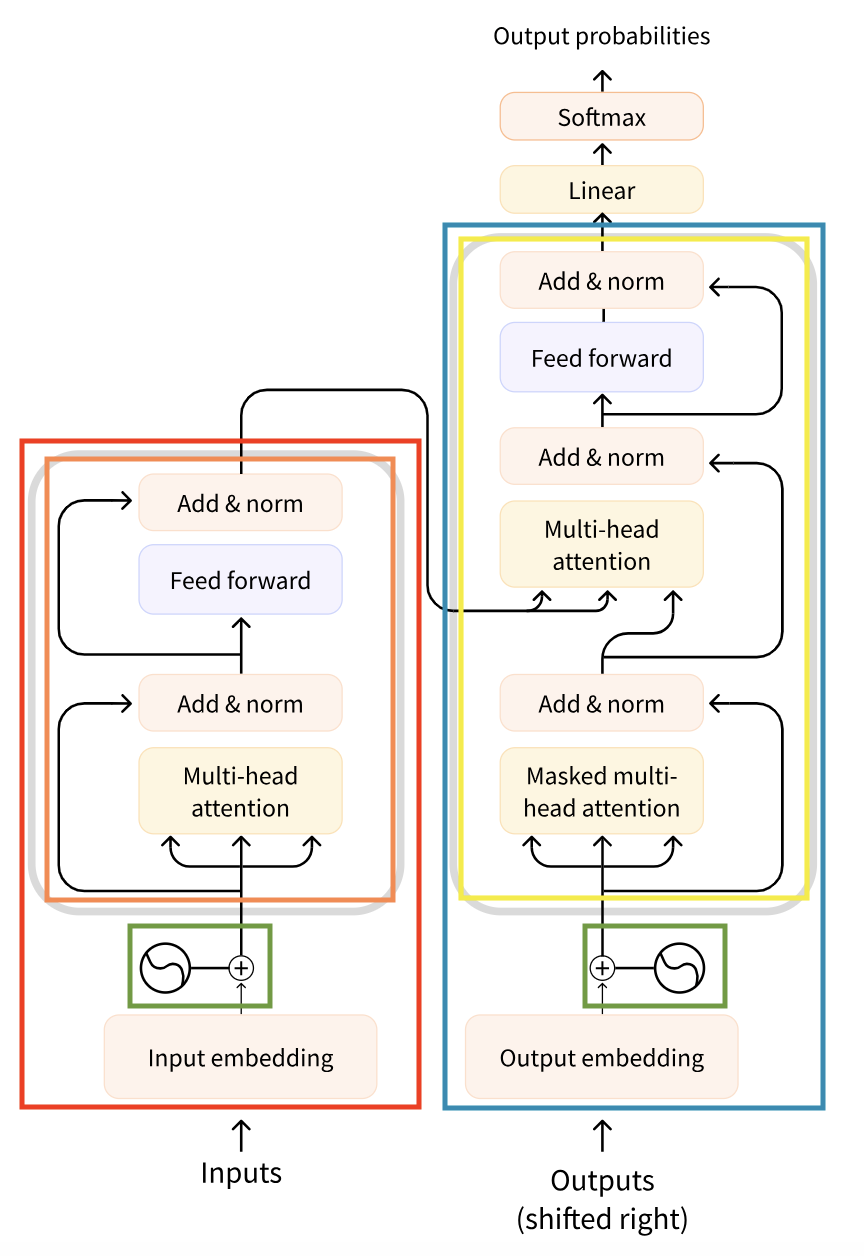

</center>

In the diagram above:

* Red box is the encoder

  - Orange box can be a stack of **N** ecoder layer (one is shown in the diagram), each containing a `GlobalSelAttention` and `FeedForward` layer

* Blue box is the decoder

  - Yellow box can be a stack of **N** decoder layer (two are shown in the diagram), each containing a `CausalSelfAttention`, `CrossAttention`, and a `FeedForward` layer

* Green boxes are the positinoal encoding

In this project, the part of the transformer architecture needed for caption generation is the decoder. Below, we implement a base attention layer, from which other attention layers can be implemented as subclasses:

In [20]:
@tf.keras.saving.register_keras_serializable(package='VisionTransformer', name='BaseAttention')
class BaseAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Residual connection
    self.add = tf.keras.layers.Add()
    # Normalization to maintain scale for the outputs
    self.layernorm = tf.keras.layers.LayerNormalization()

Note that all attention layers contain residual connection and normalization to help with efficiency during training.

### Embeddings

The input text has already been split up into tokens and converted to sequences of indices.

Unlike a CNN or RNN, the Transformer's attention layers are invariant to the order of the sequence. It needs some way to identify tokens order, otherwise it would see the input sequence as a bag of words instance. Therefore, in addition to a simple vector embedding for each *token index*, the embedding layer will also include an embedding for each *position* in the sequence.

The `SeqEmbedding` layer for each input sequence is defined as follows:

- It looks up the embedding vector for each token.

- It looks up an embedding vector for each sequence location.

- It adds the two together so that the embedding vectors encapsulate both the value and positional information of each token.

- It uses `mask_zero=True` to treat 0 as a special padding value that should be masked out. Padding is used to make all sequences in a batch the same length so they can be processed together. Setting this to `True` ignores these padding tokens when computing gradients, so they don't contribute to the model's learning. This is important because padding tokens don't carry any meaningful information and should not affect the model's understanding of the data.

In [21]:
@tf.keras.saving.register_keras_serializable(package='VisionTransformer', name='SeqEmbedding')
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)
    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True
      )
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    # Output size (batch, seq, depth)
    seq = self.token_embedding(seq)
    # Sequence of integers ranging from 0 to (seq - 1) with length (seq_length) representing positions
    x = tf.range(tf.shape(seq)[1])
    # Add dimension to match what `pos_embedding` expects, which is a (batch_size, sequence_length) 2D input
    x = x[tf.newaxis, :]
    # Output size (1, seq, depth) where depth is the output dimension specified above
    x = self.pos_embedding(x)

    # Token embeddings plus positional encoding
    return self.add([seq, x])

### Decoder

The decoder contains a stack of `DecoderLayers`, each containing three sublayers:

* `CausalSelfAttention`: The decoder generates the text one token at a time and feed that output back to the input. To make this efficient, the model ensures that the output for each sequence element only depends on the previous sequence elements, making the model "causal."

In [22]:
@tf.keras.saving.register_keras_serializable(package='VisionTransformer', name='CausalSelfAttention')
class CausalSelfAttention(BaseAttention):
  def call(self, x):
    attn = self.mha(
        query=x,
        # Since 'key' is not given, 'key' will default to 'value'
        value=x,
        # Prevent tokens from attending to future tokens
        use_causal_mask=True
    )
    x = self.add([x, attn])
    return self.layernorm(x)

* `CrossAttention`: This layer connects the extracted image features to the decoder. In the implementation below, `x` is the target sequence (tokens) and `y` is the context sequence (image features).

In [23]:
@tf.keras.saving.register_keras_serializable(package='VisionTransformer', name='CrossAttention')
class CrossAttention(BaseAttention):
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
        # X is the text features
        query=x,
        # Y is the image features, and 'key' will default to 'value'
        value=y,
        return_attention_scores=True
    )
    # Cache the attention scores for plotting
    self.last_attention_scores = attention_scores
    x = self.add([x, attn])
    return self.layernorm(x)

* `FeedForward`: The "point-wise" network consists of two linear layers with a ReLU activation in-between, and a dropout layer. The term "point-wise" comes from the fact that the same operation (the feed-forward network) is applied independently to each "point" (position) in the sequence.

In [24]:
@tf.keras.saving.register_keras_serializable(package='VisionTransformer', name='FeedForward')
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu', kernel_initializer='he_normal'),
        tf.keras.layers.Dense(units=units, activation='linear', kernel_initializer='he_normal'),
        tf.keras.layers.Dropout(rate=dropout_rate)
    ])
    self.add = tf.keras.layers.Add()
    self.layernorm = tf.keras.layers.LayerNormalization()

  def call(self, x):
    x = self.add([x, self.seq(x)])
    return self.layernorm(x)

The three layers above can be arranged into a `DecoderLayer` layer. Each decoder layer applies the three sublayers in sequence. After each sublayer, the shape of `out_seq` is `(batch, sequence, channels)`. The decoder layer also returns the `attention_scores` for visualization.

In [25]:
@tf.keras.saving.register_keras_serializable(package='VisionTransformer', name='DecoderLayer')
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()

    self.self_attention = CausalSelfAttention(
        num_heads=num_heads,
        key_dim=units,
        dropout=dropout_rate
    )
    self.cross_attention = CrossAttention(
        num_heads=num_heads,
        key_dim=units,
        dropout=dropout_rate
    )
    self.feed_forward = FeedForward(units=units, dropout_rate=dropout_rate)


  def call(self, inputs, training=False):
    # The in_seq are the image features and out_seq are the text features
    in_seq, out_seq = inputs

    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)

    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.feed_forward(out_seq)

    return out_seq

### Output

The default initialization of a dense layer will give a model that initially predicts each token with almost uniform likelihood. The actual token distribution is far from uniform. The optimal value for the initial bias of the output layer is the log of the probability of each token. So include an adapt method to count the tokens and set the optimal initial bias.

In [26]:
@tf.keras.saving.register_keras_serializable(package='VisionTransformer', name='TokenOutput')
class TokenOutput(tf.keras.layers.Layer):

  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    self.dense = tf.keras.layers.Dense(units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens
    self.bias = None

  def adapt(self, ds):

    # This is a subclass of dictionary that allows for mapping keys to counts
    counts = collections.Counter()
    vocab_dict = {name: id for id, name in enumerate(self.tokenizer.get_vocabulary())}

    # Count the occurence of each token in the dataset
    for tokens in tqdm.tqdm(ds):
      # Each token should be string after 'numpy().flatten()'
      counts.update(tokens.numpy().flatten())

    # The element counts_arr[i] is the count of the token with index 'i'
    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    # This creates a 'shallow' copy to avoid warnings
    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      # Set counts of banned tokens to zero
      counts_arr[vocab_dict[token]] = 0

    # Compute the relative frequency of each token
    total = counts_arr.sum()
    p = counts_arr / total
    # Banned token (or other tokens) with 0 counts get probabilities of 1
    p[counts_arr == 0] = 1.0
    # Log(1) == 0 for banned tokens
    log_p = np.log(p)

    entropy = -(log_p*p).sum()
    print()
    print(f'Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}')
    print(f'Marginal entropy: {entropy:0.2f}')

    # Smart initialization of bias terms using log of probability
    self.bias = log_p
    # Initialize bias terms for banned tokens with large negative numbers
    self.bias[counts_arr == 0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # Use '+' since Add layers do not work with 'x' and 'self.bias' having different shapes
    return x + self.bias

Adapt the output layer to the training set:

In [27]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

938it [00:23, 40.16it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


### Model Class

We build a model class by subclassing `tf.keras.Model`, which provides the high-level `fit` API. It also allows us to tune the hyperparameters using `optuna`.

In [28]:
@tf.keras.saving.register_keras_serializable(package='VisionTransformer', name='CaptionModel')
class CaptionModel(tf.keras.Model):
  """
  A custom Keras Model for image captioning.
  """
  def __init__(self,
               tokenizer: tf.keras.layers.TextVectorization,
               feature_extractor: tf.keras.Model,
               output_layer: TokenOutput,
               units: int,
               num_layers: int = 1,
               max_length: int = 50,
               num_heads: int = 1,
               dropout_rate: float = 0.1):
    """
    Constructor for the model.

    Parameters
    ----------
    tokenizer : tf.keras.layers.TextVectorization
        A tokenizer object used to convert between text and numeric tokens.
    feature_extractor : tf.keras.Model
        A feature extractor model (e.g., a ConvNet) to extract features from images.
    output_layer : TokenOutput
        An output layer that predicts the next token.
    units : int
        The dimensionality of the output space.
    num_layers : int, optional
        Number of decoder layers in the model, default is 1.
    max_length : int, optional
        The maximum length of the sequence, default is 50.
    num_heads : int, optional
        The number of attention heads for the multi-head attention mechanisms, default is 1.
    dropout_rate : float, optional
        The dropout rate, default is 0.1.
    """
    super().__init__()
    # Feature extractor for image data
    self.feature_extractor = feature_extractor
    # Tokenizer for text data
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(mask_token='', vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(mask_token='', vocabulary=tokenizer.get_vocabulary(), invert=True)
    self.max_length = max_length
    # Token embedding and positional encoding
    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=self.max_length
    )
    # Stack of decoder layers
    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate) for n in range(num_layers)
    ]
    # The output layer predicts a point-wise prediction of the next token
    self.output_layer = output_layer

  def call(self, inputs: Tuple[tf.Tensor, tf.Tensor]) -> tf.Tensor:
    """
    Forward pass for the model.

    Parameters
    ----------
    inputs : Tuple[tf.Tensor, tf.Tensor]
        A tuple containing an image tensor and a text tensor.

    Returns
    -------
    tf.Tensor
        The output tensor after passing through the model.
    """
    # Each inputs is (image, txt) pair
    image, txt = inputs

    # If RBG, apply the feature-extractor
    if image.shape[-1] == 3:
      image = self.feature_extractor(image)

    # Flatten the feature maps' spatial dimensions
    image = einops.rearrange(image, 'b h w c -> b (h w) c')

    # Apply the tokenizerfor string inputs
    if txt.dtype == tf.string:
      txt = tokenizer(txt)

    # Token embedding and positional encoding
    txt = self.seq_embedding(txt)

    # Apply self-attention to the tokens and cross-attention between the tokens and the images
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))

    # Predict next token
    txt = self.output_layer(txt)

    return txt

  def generate_caption(self, image: tf.Tensor, temperature: float = 1.0) -> str:
      """
      Generate a caption for an image.

      Parameters
      ----------
      image : tf.Tensor
        A tensor representing the image to be captioned, which should be resized to match what the feature extractor expects.
      temperature : float, optional
          A parameter controlling the randomness of the token predictions. Higher values produce more random outputs, default is 1.0.

      Returns
      -------
      str
          The generated caption as a string.
      """
      # Add batch dimension and extract features
      img_features = self.feature_extractor(image[tf.newaxis, ...])

      # Initial tokens with shape (batch, sequence)
      initial = self.word_to_index([['[START]']])
      tokens = initial
      for n in range(self.max_length):

        # Shape (batch, sequence, vocab)
        preds = self((img_features, tokens)).numpy()
        # Shape (batch, vocab)
        preds = preds[:, -1, :]

        # The prediction 'next' has shape (batch, 1)
        if temperature == 0.0:
          next = tf.argmax(preds, axis=-1)[:, tf.newaxis]
        else:
          next = tf.random.categorical(preds / temperature, num_samples=1)
        # Shape (batch, sequence)
        tokens = tf.concat([tokens, next], axis=1)

        # Break out of the generation loop once the 'END' token is predicted
        if next[0] == self.word_to_index('[END]'):
          break

      # Convert to string
      words = self.index_to_word(tokens[0, 1:-1])  # Fixed line
      result = tf.strings.reduce_join(words, axis=-1, separator=' ')

      return result.numpy().decode()

  def plot_attention_maps(self, image: tf.Tensor, str_tokens: List[str], attention_map: tf.Tensor, figsize: Tuple[int, int] = (16, 9)) -> None:
      """
      Plot the attention maps over the image.

      Parameters
      ----------
      image : tf.Tensor
          A tensor representing the image.
      str_tokens : List[str]
          The list of string tokens.
      attention_map : tf.Tensor
          The attention map tensor.
      figsize : Tuple[int, int], optional
          The size of the figure, by default (16, 9).
      """
      fig = plt.figure(figsize=figsize)
      len_result = len(str_tokens)

      for i in range(len_result):
        map = attention_map[i]
        grid_size = max(int(np.ceil(len_result / 2)), 2)
        ax = fig.add_subplot(3, grid_size, i + 1)
        ax.set_title(str_tokens[i])
        img = ax.imshow(image)
        ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(), clim=[0.0, np.max(map)])

      plt.tight_layout()

  def generate_caption_and_plot(self, image: tf.Tensor, temperature: float = 0.0) -> None:
      """
      Generate a caption for an image and plot the attention maps.

      Parameters
      ----------
      image : tf.Tensor
          A tensor representing the image to be captioned.
      temperature : float, optional
          A parameter controlling the randomness of the token predictions. Higher values produce more random outputs, default is 0.0.
      """
      result_txt = self.generate_caption(image, temperature)
      str_tokens = result_txt.split()
      str_tokens.append('[END]')

      attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
      attention_maps = tf.concat(attention_maps, axis=0)
      attention_maps = einops.reduce(
          attention_maps,
          'batch heads sequence (height width) -> sequence height width',
          height=7, width=7,
          reduction='mean'
      )

      self.plot_attention_maps(image / 255, str_tokens, attention_maps)
      t = plt.suptitle(result_txt)
      t.set_y(1.05)

## Training

### Loss and Metric

In [29]:
@tf.keras.saving.register_keras_serializable(package='VisionTransformer', name='masked_loss')
def masked_loss(labels: tf.Tensor, preds: tf.Tensor) -> tf.Tensor:
    """
    Compute the masked loss.

    Parameters
    ----------
    labels : tf.Tensor
        The true labels.
    preds : tf.Tensor
        The predicted labels.

    Returns
    -------
    tf.Tensor
        The computed masked loss.
    """
    # Measures the probability error in discrete classification tasks in which the classes are mutually exclusive
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

    # Discard the large losses for 'banned_tokens'
    mask = (labels != 0) & (loss < 1e8)
    mask = tf.cast(mask, loss.dtype)

    loss = loss * mask
    # Average loss for elements where the mask is 1
    loss = tf.reduce_sum(loss) / tf.reduce_sum(mask)
    return loss

@tf.keras.saving.register_keras_serializable(package='VisionTransformer', name='masked_acc')
def masked_acc(labels: tf.Tensor, preds: tf.Tensor) -> tf.Tensor:
    """
    Compute the masked accuracy.

    Parameters
    ----------
    labels : tf.Tensor
        The true labels.
    preds : tf.Tensor
        The predicted labels.

    Returns
    -------
    tf.Tensor
        The computed masked accuracy.
    """
    mask = tf.cast(labels != 0, tf.float32)
    preds = tf.argmax(preds, axis=-1)
    labels = tf.cast(labels, tf.int64)
    matched = tf.cast(preds == labels, mask.dtype)
    acc = tf.reduce_sum(matched * mask) / tf.reduce_sum(mask)
    return acc

Next, we implement a `trainer` class that accepts a dictionary of hyperparameters, datasets, and other classes, training the model and returning the model and the metric on the test set.

In [30]:
class Trainer(object):
  """
  This class encapsulates the training of the vision transformer model.
  """
  def __init__(self,
               train_ds: tf.data.Dataset,
               test_ds: tf.data.Dataset,
               feature_extractor: tf.keras.Model,
               tokenizer: tf.keras.layers.TextVectorization,
               output_layer: TokenOutput,
               hyperparameters: Dict[str, Any],
               steps_per_epoch: int,
               validation_steps: int,
               patience: int = 5,
               min_delta: float = 1e-3,
               restore_best_model: bool = True):
    """
    Constructor for the Trainer class.

    Parameters
    ----------
    train_ds : tf.data.Dataset
        The training dataset.
    test_ds : tf.data.Dataset
        The testing dataset.
    feature_extractor : tf.keras.Model
        A feature extractor model (e.g., a ConvNet) to extract features from images.
    tokenizer : tf.keras.layers.TextVectorization
        A tokenizer object used to convert between text and numeric tokens (must be adapted to the training set).
    output_layer: TokenOutput
        A token output layer that is adapted to the training set.
    hyperparameters : Dict[str, Any]
        A dictionary containing the hyperparameters for model training.
    steps_per_epoch: int
        Total number of steps (batches of samples) before declaring one epoch finished, typically set to ceil(num_of_samples / batch_size).
    validation_steps: int
        Total number of steps (batches of samples) to draw before stopping when performing validation, again, usually set to ceil(num_of_samples / batch_size).
    patience : int, optional
        The number of epochs to wait before stopping training if the validation loss does not improve,
        by default 5.
    min_delta : float, optional
        The minimum change in validation loss to qualify as an improvement, by default 1e-3.
    restore_best_model : bool, optional
        Whether to restore the model with the lowest validation loss found during training after
        training has ended, by default True.
    """
    self.train_ds = train_ds
    self.test_ds = test_ds
    self.tokenizer = tokenizer
    self.feature_extractor = feature_extractor
    self.output_layer = output_layer
    self.hyperparameters = hyperparameters
    self.steps_per_epoch = steps_per_epoch
    self.validation_steps = validation_steps
    self.patience = patience
    self.min_delta = min_delta
    self.restore_best_model = restore_best_model

  def fit(self) -> Tuple[CaptionModel, tf.keras.callbacks.EarlyStopping]:
    """
    Model training.

    Returns
    -------
    Tuple[CaptionModel, tf.keras.callbacks.EarlyStopping]
        The trained CaptionModel and the EarlyStopping callback used during training. The callback can be used to obtain information about the training process, such
        as the epoch in which training was stopped.
    """
    # Instantiate the model
    model = CaptionModel(
        tokenizer=self.tokenizer,
        feature_extractor=self.feature_extractor,
        output_layer=self.output_layer,
        num_layers=self.hyperparameters['num_layers'],
        units=self.hyperparameters['units'],
        max_length=50,
        num_heads=self.hyperparameters['num_heads'],
        dropout_rate=0.1
    )

    # Optimizer
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=self.hyperparameters['learning_rate'],
        beta_1=self.hyperparameters['beta_1'],
        beta_2=self.hyperparameters['beta_2'],
        epsilon=self.hyperparameters['epsilon'],
        clipnorm=self.hyperparameters['clipnorm']
    )

    # Compile the model
    model.compile(
        optimizer=optimizer,
        loss=masked_loss,
        metrics=[masked_acc]
    )

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_masked_acc',
        patience=self.patience,
        min_delta=self.min_delta,
        restore_best_weights=self.restore_best_model
    )

    model.fit(
        x=self.train_ds.repeat(),
        steps_per_epoch=self.steps_per_epoch,
        validation_data=self.test_ds.repeat(),
        validation_steps=self.validation_steps,
        epochs=self.hyperparameters['epochs'],
        callbacks=[early_stopping]
    )

    return model, early_stopping

### Hyperparameter Tuning with Optuna

We define a surragote objective function, wrapping the `CaptionModel` subclass and train the model with multiple trials, each with a different combination of hyperparameters.

The hyperparameters for the model architecture:

* `num_layers`: number of decoder layers

* `num_heads`: number of "attention heads" in the multi-head attention mechanism

The hyperparameters for the optimizer:

* `adam_learning_rate`: learning rate

* `adam_beta_1`: exponential decay rate for the 1st moment estimates

* `adam_beta_2`: exponential decay rate for the 2nd moment estimates

* `adam_epsilon`: a constant for numerical stability

* `adam_clipnorm`: threshold value above which the gradient of each weight is individually clipped

* `fit_epochs`: number of epochs to train the model

The metric that we will monitor is the masked accuracy:

In [31]:
def objective(trial: optuna.Trial,
              train_data: Dict[str, tf.data.Dataset],
              test_data: Dict[str, tf.data.Dataset],
              feature_extractor: tf.keras.Model,
              tokenizer: tf.keras.layers.TextVectorization,
              output_layer: TokenOutput,
              batch_size: int,
              patience: int = 5,
              min_delta: float = 1e-3,
              restore_best_model: bool = True):
    """
    Surrogate objective function for optuna.

    Parameters
    ----------
    trial : optuna.Trial
        An optuna trial object.
    train_data : Dict[str, tf.data.Dataset]
        A dictionary containing the training data and raw data for computing steps per epoch.
    test_data : Dict[str, tf.data.Dataset]
        A dictionary containing the testing data and raw data for computing validation steps.
    feature_extractor : tf.keras.Model
        A feature extractor model (e.g., a ConvNet) to extract features from images.
    tokenizer : tf.keras.layers.TextVectorization
        A tokenizer object used to convert between text and numeric tokens (must be adapted to the training set).
    output_layer: TokenOutput
        A token output layer that is adapted to the training set.
    batch_size : int
        The batch size.
    patience : int, optional
        The number of epochs to wait before stopping training if the validation loss does not improve,
        by default 5.
    min_delta : float, optional
        The minimum change in validation loss to qualify as an improvement, by default 1e-3.
    restore_best_model : bool, optional
        Whether to restore the model with the lowest validation loss found during training after
        training has ended, by default True.

    Returns
    -------
    float
        The validation loss.
    """
    search_space = {
        'num_layers': trial.suggest_int('num_layers', 1, 4),
        'units': trial.suggest_categorical('units', [256]),
        'num_heads': trial.suggest_int('num_heads', 4, 8),
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        'beta_1': trial.suggest_float('beta_1', 0.6, 0.9),
        'beta_2': trial.suggest_float('beta_2', 0.8, 0.999),
        'epsilon': trial.suggest_float('epsilon', 1e-7, 1.0, log=True),
        'clipnorm': trial.suggest_float('clipnorm', 0.1, 1.0),
        'epochs': trial.suggest_int('epochs', 15, 30)
    }

    # Instantiate the trainer
    trainer = Trainer(
        train_ds=train_data['train_ds'],
        test_ds=test_data['test_ds'],
        feature_extractor=feature_extractor,
        tokenizer=tokenizer,
        output_layer=output_layer,
        hyperparameters=search_space,
        steps_per_epoch=np.ceil(len(train_data['train_raw']) / batch_size),
        validation_steps=np.ceil(len(test_data['test_raw']) / batch_size),
        patience=patience,
        min_delta=min_delta,
        restore_best_model=restore_best_model
    )

    model, early_stopping = trainer.fit()

    return early_stopping.best

Next, we set up the Optuna hyperparameter optimization as follows:

In [32]:
def create_study(study_name: str, storage: str, direction: str = 'minimize') -> optuna.study.Study:
    """
    Create Optuna study instance.

    Parameters
    ----------
    study_name : str
        Name of the study.
    storage : str
        Database url.
    direction: str
        Direction of the metric--- maximize or minimize.

    Returns
    -------
    optuna.study.Study
        Optuna study instance.
    """
    study = optuna.create_study(
        storage=storage,
        sampler=optuna.samplers.TPESampler(),
        study_name=study_name,
        direction=direction,
        load_if_exists=True
    )

    return study

The wrapper function allows us to pass multiple arguments to the objective function while maintaining usability with Optuna, which requires that the objective function passed to `optimize` has one argument `trial`:

In [33]:
def objective_wrapper(trial: optuna.Trial) -> Callable:
    return objective(
        trial=trial,
        train_data={'train_ds': train_ds, 'train_raw': train_raw},
        test_data={'test_ds': test_ds, 'test_raw': test_raw},
        feature_extractor=mobilenetv3_large,
        tokenizer=tokenizer,
        output_layer=output_layer,
        batch_size=batch_size
    )

We run 15 trials of training with different combination of hyperparameters:

In [34]:
study = create_study(study_name='vision-transformer-hpo', storage=None, direction='maximize')
study.optimize(objective_wrapper, n_trials=15)

[I 2023-08-03 04:48:38,330] A new study created in memory with name: vision-transformer-hpo


Epoch 1/17
188/188 [==============================] - 55s 183ms/step - loss: 5.0509 - masked_acc: 0.1898 - val_loss: 4.8094 - val_masked_acc: 0.2210
Epoch 2/17
188/188 [==============================] - 21s 110ms/step - loss: 4.7798 - masked_acc: 0.2347 - val_loss: 4.6258 - val_masked_acc: 0.2407
Epoch 3/17
188/188 [==============================] - 19s 101ms/step - loss: 4.5928 - masked_acc: 0.2550 - val_loss: 4.4419 - val_masked_acc: 0.2674
Epoch 4/17
188/188 [==============================] - 19s 99ms/step - loss: 4.4675 - masked_acc: 0.2719 - val_loss: 4.3545 - val_masked_acc: 0.2819
Epoch 5/17
188/188 [==============================] - 20s 106ms/step - loss: 4.3829 - masked_acc: 0.2852 - val_loss: 4.2652 - val_masked_acc: 0.2867
Epoch 6/17
188/188 [==============================] - 18s 97ms/step - loss: 4.2262 - masked_acc: 0.2982 - val_loss: 4.1409 - val_masked_acc: 0.2996
Epoch 7/17
188/188 [==============================] - 19s 99ms/step - loss: 4.1632 - masked_acc: 0.3105 - va

[I 2023-08-03 04:54:37,022] Trial 0 finished with value: 0.35345372557640076 and parameters: {'num_layers': 2, 'units': 256, 'num_heads': 5, 'learning_rate': 2.213121786296481e-05, 'beta_1': 0.6272879273137598, 'beta_2': 0.9780954374363569, 'epsilon': 4.6044093348332395e-05, 'clipnorm': 0.6262067612532594, 'epochs': 17}. Best is trial 0 with value: 0.35345372557640076.


Epoch 1/22
188/188 [==============================] - 63s 199ms/step - loss: 5.2821 - masked_acc: 0.1293 - val_loss: 5.1436 - val_masked_acc: 0.1380
Epoch 2/22
188/188 [==============================] - 22s 116ms/step - loss: 5.1483 - masked_acc: 0.1319 - val_loss: 5.1510 - val_masked_acc: 0.1292
Epoch 3/22
188/188 [==============================] - 21s 114ms/step - loss: 5.1136 - masked_acc: 0.1311 - val_loss: 5.0738 - val_masked_acc: 0.1330
Epoch 4/22
188/188 [==============================] - 20s 108ms/step - loss: 5.0740 - masked_acc: 0.1313 - val_loss: 5.0689 - val_masked_acc: 0.1333
Epoch 5/22
188/188 [==============================] - 20s 109ms/step - loss: 5.0559 - masked_acc: 0.1289 - val_loss: 5.1068 - val_masked_acc: 0.1332
Epoch 6/22
188/188 [==============================] - 21s 110ms/step - loss: 5.0020 - masked_acc: 0.1329 - val_loss: 5.0256 - val_masked_acc: 0.1211


[I 2023-08-03 04:57:26,585] Trial 1 finished with value: 0.1379845291376114 and parameters: {'num_layers': 3, 'units': 256, 'num_heads': 4, 'learning_rate': 0.00736398827846071, 'beta_1': 0.6867421554890677, 'beta_2': 0.9077701358387665, 'epsilon': 1.9585260079495517e-05, 'clipnorm': 0.37859595450587546, 'epochs': 22}. Best is trial 0 with value: 0.35345372557640076.


Epoch 1/28
188/188 [==============================] - 45s 167ms/step - loss: 5.3238 - masked_acc: 0.1264 - val_loss: 5.1825 - val_masked_acc: 0.1336
Epoch 2/28
188/188 [==============================] - 19s 102ms/step - loss: 5.1674 - masked_acc: 0.1302 - val_loss: 5.1162 - val_masked_acc: 0.1220
Epoch 3/28
188/188 [==============================] - 16s 86ms/step - loss: 5.1359 - masked_acc: 0.1296 - val_loss: 5.1182 - val_masked_acc: 0.1329
Epoch 4/28
188/188 [==============================] - 16s 87ms/step - loss: 5.1086 - masked_acc: 0.1303 - val_loss: 5.0791 - val_masked_acc: 0.1291
Epoch 5/28
188/188 [==============================] - 17s 88ms/step - loss: 5.1050 - masked_acc: 0.1301 - val_loss: 5.0819 - val_masked_acc: 0.1204
Epoch 6/28
188/188 [==============================] - 17s 88ms/step - loss: 5.0313 - masked_acc: 0.1300 - val_loss: 5.0010 - val_masked_acc: 0.1215


[I 2023-08-03 04:59:38,447] Trial 2 finished with value: 0.1336139440536499 and parameters: {'num_layers': 1, 'units': 256, 'num_heads': 4, 'learning_rate': 0.031794626696847184, 'beta_1': 0.7595243577652975, 'beta_2': 0.8264407961537202, 'epsilon': 0.0037225695364063002, 'clipnorm': 0.7867904044619656, 'epochs': 28}. Best is trial 0 with value: 0.35345372557640076.


Epoch 1/18
188/188 [==============================] - 72s 212ms/step - loss: 4.3737 - masked_acc: 0.2620 - val_loss: 3.9290 - val_masked_acc: 0.3144
Epoch 2/18
188/188 [==============================] - 24s 127ms/step - loss: 3.8437 - masked_acc: 0.3299 - val_loss: 3.6699 - val_masked_acc: 0.3402
Epoch 3/18
188/188 [==============================] - 25s 136ms/step - loss: 3.6512 - masked_acc: 0.3528 - val_loss: 3.5483 - val_masked_acc: 0.3526
Epoch 4/18
188/188 [==============================] - 24s 125ms/step - loss: 3.5828 - masked_acc: 0.3615 - val_loss: 3.4393 - val_masked_acc: 0.3644
Epoch 5/18
188/188 [==============================] - 25s 133ms/step - loss: 3.4932 - masked_acc: 0.3731 - val_loss: 3.4602 - val_masked_acc: 0.3587
Epoch 6/18
188/188 [==============================] - 23s 123ms/step - loss: 3.2463 - masked_acc: 0.4020 - val_loss: 3.4319 - val_masked_acc: 0.3562
Epoch 7/18
188/188 [==============================] - 24s 129ms/step - loss: 3.2840 - masked_acc: 0.3959 -

[I 2023-08-03 05:07:45,026] Trial 3 finished with value: 0.39439424872398376 and parameters: {'num_layers': 4, 'units': 256, 'num_heads': 6, 'learning_rate': 0.00017440201997891047, 'beta_1': 0.6049067567459568, 'beta_2': 0.9161727794141864, 'epsilon': 1.4940497694186194e-06, 'clipnorm': 0.8058386753892225, 'epochs': 18}. Best is trial 3 with value: 0.39439424872398376.


Epoch 1/20
188/188 [==============================] - 74s 220ms/step - loss: 4.8241 - masked_acc: 0.2065 - val_loss: 4.3805 - val_masked_acc: 0.2551
Epoch 2/20
188/188 [==============================] - 24s 127ms/step - loss: 4.3539 - masked_acc: 0.2635 - val_loss: 4.1342 - val_masked_acc: 0.2761
Epoch 3/20
188/188 [==============================] - 23s 125ms/step - loss: 4.1678 - masked_acc: 0.2846 - val_loss: 3.9947 - val_masked_acc: 0.2970
Epoch 4/20
188/188 [==============================] - 23s 121ms/step - loss: 4.0613 - masked_acc: 0.3012 - val_loss: 3.8469 - val_masked_acc: 0.3140
Epoch 5/20
188/188 [==============================] - 24s 128ms/step - loss: 3.9405 - masked_acc: 0.3116 - val_loss: 3.8130 - val_masked_acc: 0.3148
Epoch 6/20
188/188 [==============================] - 23s 125ms/step - loss: 3.7472 - masked_acc: 0.3324 - val_loss: 3.7376 - val_masked_acc: 0.3222
Epoch 7/20
188/188 [==============================] - 23s 125ms/step - loss: 3.7412 - masked_acc: 0.3348 -

[I 2023-08-03 05:16:24,516] Trial 4 finished with value: 0.36276775598526 and parameters: {'num_layers': 4, 'units': 256, 'num_heads': 5, 'learning_rate': 2.273932547492802e-05, 'beta_1': 0.6190485012619681, 'beta_2': 0.9253477418595706, 'epsilon': 7.571703975396009e-05, 'clipnorm': 0.6204043956766446, 'epochs': 20}. Best is trial 3 with value: 0.39439424872398376.


Epoch 1/27
188/188 [==============================] - 55s 192ms/step - loss: 4.0047 - masked_acc: 0.2960 - val_loss: 3.6078 - val_masked_acc: 0.3275
Epoch 2/27
188/188 [==============================] - 21s 114ms/step - loss: 3.5463 - masked_acc: 0.3455 - val_loss: 3.4130 - val_masked_acc: 0.3434
Epoch 3/27
188/188 [==============================] - 20s 108ms/step - loss: 3.3809 - masked_acc: 0.3605 - val_loss: 3.2874 - val_masked_acc: 0.3642
Epoch 4/27
188/188 [==============================] - 19s 101ms/step - loss: 3.2734 - masked_acc: 0.3691 - val_loss: 3.2110 - val_masked_acc: 0.3684
Epoch 5/27
188/188 [==============================] - 20s 105ms/step - loss: 3.1813 - masked_acc: 0.3809 - val_loss: 3.1898 - val_masked_acc: 0.3663
Epoch 6/27
188/188 [==============================] - 19s 103ms/step - loss: 2.9582 - masked_acc: 0.4044 - val_loss: 3.1306 - val_masked_acc: 0.3741
Epoch 7/27
188/188 [==============================] - 19s 103ms/step - loss: 2.9661 - masked_acc: 0.4031 -

[I 2023-08-03 05:21:54,429] Trial 5 finished with value: 0.39191490411758423 and parameters: {'num_layers': 2, 'units': 256, 'num_heads': 8, 'learning_rate': 0.004753873978595196, 'beta_1': 0.7488198540676188, 'beta_2': 0.811724413382513, 'epsilon': 0.0039610131422897765, 'clipnorm': 0.12416281795089713, 'epochs': 27}. Best is trial 3 with value: 0.39439424872398376.


Epoch 1/21
188/188 [==============================] - 62s 192ms/step - loss: 4.0667 - masked_acc: 0.2820 - val_loss: 3.5991 - val_masked_acc: 0.3239
Epoch 2/21
188/188 [==============================] - 22s 117ms/step - loss: 3.5322 - masked_acc: 0.3378 - val_loss: 3.4440 - val_masked_acc: 0.3368
Epoch 3/21
188/188 [==============================] - 21s 114ms/step - loss: 3.3710 - masked_acc: 0.3566 - val_loss: 3.3326 - val_masked_acc: 0.3483
Epoch 4/21
188/188 [==============================] - 22s 116ms/step - loss: 3.2943 - masked_acc: 0.3621 - val_loss: 3.2412 - val_masked_acc: 0.3626
Epoch 5/21
188/188 [==============================] - 21s 114ms/step - loss: 3.2369 - masked_acc: 0.3673 - val_loss: 3.2173 - val_masked_acc: 0.3590
Epoch 6/21
188/188 [==============================] - 21s 113ms/step - loss: 3.0315 - masked_acc: 0.3923 - val_loss: 3.1369 - val_masked_acc: 0.3785
Epoch 7/21
188/188 [==============================] - 20s 107ms/step - loss: 3.0429 - masked_acc: 0.3909 -

[I 2023-08-03 05:29:58,500] Trial 6 finished with value: 0.39825600385665894 and parameters: {'num_layers': 3, 'units': 256, 'num_heads': 5, 'learning_rate': 0.0008453904382261424, 'beta_1': 0.6143218837529503, 'beta_2': 0.8489819188391807, 'epsilon': 0.0052132567311625215, 'clipnorm': 0.6113344659091157, 'epochs': 21}. Best is trial 6 with value: 0.39825600385665894.


Epoch 1/16
188/188 [==============================] - 61s 198ms/step - loss: 5.7169 - masked_acc: 0.1222 - val_loss: 5.5105 - val_masked_acc: 0.1319
Epoch 2/16
188/188 [==============================] - 22s 119ms/step - loss: 5.4712 - masked_acc: 0.1313 - val_loss: 5.4218 - val_masked_acc: 0.1306
Epoch 3/16
188/188 [==============================] - 21s 112ms/step - loss: 5.4987 - masked_acc: 0.1342 - val_loss: 5.4572 - val_masked_acc: 0.1322
Epoch 4/16
188/188 [==============================] - 20s 108ms/step - loss: 5.5686 - masked_acc: 0.1291 - val_loss: 5.5246 - val_masked_acc: 0.1344
Epoch 5/16
188/188 [==============================] - 21s 111ms/step - loss: 5.5816 - masked_acc: 0.1304 - val_loss: 5.6501 - val_masked_acc: 0.1301
Epoch 6/16
188/188 [==============================] - 20s 104ms/step - loss: 5.6069 - masked_acc: 0.1293 - val_loss: 5.6630 - val_masked_acc: 0.1253
Epoch 7/16
188/188 [==============================] - 20s 105ms/step - loss: 5.6398 - masked_acc: 0.1283 -

[I 2023-08-03 05:33:46,841] Trial 7 finished with value: 0.13440589606761932 and parameters: {'num_layers': 3, 'units': 256, 'num_heads': 4, 'learning_rate': 0.03892399606324827, 'beta_1': 0.8937262865017688, 'beta_2': 0.8193281690558304, 'epsilon': 2.956359043355966e-06, 'clipnorm': 0.40282035007246775, 'epochs': 16}. Best is trial 6 with value: 0.39825600385665894.


Epoch 1/15
188/188 [==============================] - 47s 174ms/step - loss: 34.8240 - masked_acc: 3.6216e-04 - val_loss: 28.1608 - val_masked_acc: 0.0018
Epoch 2/15
188/188 [==============================] - 17s 93ms/step - loss: 25.7998 - masked_acc: 0.0010 - val_loss: 20.7593 - val_masked_acc: 0.0035
Epoch 3/15
188/188 [==============================] - 17s 89ms/step - loss: 19.7305 - masked_acc: 0.0064 - val_loss: 15.8097 - val_masked_acc: 0.0573
Epoch 4/15
188/188 [==============================] - 16s 88ms/step - loss: 15.7460 - masked_acc: 0.0344 - val_loss: 12.5748 - val_masked_acc: 0.0755
Epoch 5/15
188/188 [==============================] - 17s 92ms/step - loss: 13.1869 - masked_acc: 0.0563 - val_loss: 10.8298 - val_masked_acc: 0.1100
Epoch 6/15
188/188 [==============================] - 16s 87ms/step - loss: 11.7855 - masked_acc: 0.0706 - val_loss: 9.7487 - val_masked_acc: 0.1373
Epoch 7/15
188/188 [==============================] - 16s 87ms/step - loss: 10.7349 - masked_acc

[I 2023-08-03 05:38:29,187] Trial 8 finished with value: 0.1722489595413208 and parameters: {'num_layers': 1, 'units': 256, 'num_heads': 5, 'learning_rate': 8.128310652904547e-05, 'beta_1': 0.7936003313747605, 'beta_2': 0.8494804665261959, 'epsilon': 0.19798656503752252, 'clipnorm': 0.8594767699696861, 'epochs': 15}. Best is trial 6 with value: 0.39825600385665894.


Epoch 1/28
188/188 [==============================] - 53s 183ms/step - loss: 7.2484 - masked_acc: 0.1590 - val_loss: 5.2746 - val_masked_acc: 0.2570
Epoch 2/28
188/188 [==============================] - 20s 105ms/step - loss: 4.9664 - masked_acc: 0.2738 - val_loss: 4.5202 - val_masked_acc: 0.3007
Epoch 3/28
188/188 [==============================] - 19s 102ms/step - loss: 4.4565 - masked_acc: 0.3098 - val_loss: 4.2738 - val_masked_acc: 0.3107
Epoch 4/28
188/188 [==============================] - 19s 99ms/step - loss: 4.2437 - masked_acc: 0.3243 - val_loss: 4.1262 - val_masked_acc: 0.3176
Epoch 5/28
188/188 [==============================] - 20s 108ms/step - loss: 4.0368 - masked_acc: 0.3359 - val_loss: 4.0197 - val_masked_acc: 0.3256
Epoch 6/28
188/188 [==============================] - 19s 101ms/step - loss: 3.7657 - masked_acc: 0.3580 - val_loss: 3.8722 - val_masked_acc: 0.3539
Epoch 7/28
188/188 [==============================] - 21s 111ms/step - loss: 3.7068 - masked_acc: 0.3621 - 

[I 2023-08-03 05:46:57,812] Trial 9 finished with value: 0.3836058974266052 and parameters: {'num_layers': 2, 'units': 256, 'num_heads': 6, 'learning_rate': 0.00017013041523901475, 'beta_1': 0.7122794562751779, 'beta_2': 0.8107581415323392, 'epsilon': 7.758331765629525e-06, 'clipnorm': 0.4116849993153131, 'epochs': 28}. Best is trial 6 with value: 0.39825600385665894.


Epoch 1/24
188/188 [==============================] - 65s 200ms/step - loss: 7.7788 - masked_acc: 0.0929 - val_loss: 5.5122 - val_masked_acc: 0.1241
Epoch 2/24
188/188 [==============================] - 25s 132ms/step - loss: 5.3535 - masked_acc: 0.1266 - val_loss: 5.2655 - val_masked_acc: 0.1289
Epoch 3/24
188/188 [==============================] - 25s 133ms/step - loss: 5.2869 - masked_acc: 0.1279 - val_loss: 5.4304 - val_masked_acc: 0.1279
Epoch 4/24
188/188 [==============================] - 24s 125ms/step - loss: 5.2688 - masked_acc: 0.1273 - val_loss: 5.2354 - val_masked_acc: 0.1301
Epoch 5/24
188/188 [==============================] - 22s 120ms/step - loss: 5.2236 - masked_acc: 0.1330 - val_loss: 5.2734 - val_masked_acc: 0.1297
Epoch 6/24
188/188 [==============================] - 22s 120ms/step - loss: 5.0774 - masked_acc: 0.1279 - val_loss: 5.1774 - val_masked_acc: 0.1314
Epoch 7/24
188/188 [==============================] - 22s 117ms/step - loss: 5.0992 - masked_acc: 0.1262 -

[I 2023-08-03 05:51:58,178] Trial 10 finished with value: 0.1313675045967102 and parameters: {'num_layers': 3, 'units': 256, 'num_heads': 8, 'learning_rate': 0.0011999619640426808, 'beta_1': 0.6658658300385097, 'beta_2': 0.8654460756838812, 'epsilon': 3.018885138783611e-07, 'clipnorm': 0.9778748799410746, 'epochs': 24}. Best is trial 6 with value: 0.39825600385665894.


Epoch 1/19
188/188 [==============================] - 72s 213ms/step - loss: 7.7203 - masked_acc: 0.1268 - val_loss: 4.8940 - val_masked_acc: 0.2444
Epoch 2/19
188/188 [==============================] - 26s 139ms/step - loss: 4.6987 - masked_acc: 0.2687 - val_loss: 4.3124 - val_masked_acc: 0.2960
Epoch 3/19
188/188 [==============================] - 25s 135ms/step - loss: 4.1670 - masked_acc: 0.3062 - val_loss: 4.0525 - val_masked_acc: 0.3117
Epoch 4/19
188/188 [==============================] - 25s 134ms/step - loss: 3.9411 - masked_acc: 0.3251 - val_loss: 3.8619 - val_masked_acc: 0.3268
Epoch 5/19
188/188 [==============================] - 25s 135ms/step - loss: 3.7486 - masked_acc: 0.3436 - val_loss: 3.7249 - val_masked_acc: 0.3413
Epoch 6/19
188/188 [==============================] - 24s 128ms/step - loss: 3.5535 - masked_acc: 0.3616 - val_loss: 3.7426 - val_masked_acc: 0.3426
Epoch 7/19
188/188 [==============================] - 25s 133ms/step - loss: 3.5309 - masked_acc: 0.3638 -

[I 2023-08-03 06:01:25,088] Trial 11 finished with value: 0.3689596354961395 and parameters: {'num_layers': 4, 'units': 256, 'num_heads': 7, 'learning_rate': 0.0003617630468748678, 'beta_1': 0.6079886413826586, 'beta_2': 0.8805437837472948, 'epsilon': 4.551166173344963e-07, 'clipnorm': 0.7605594333030459, 'epochs': 19}. Best is trial 6 with value: 0.39825600385665894.


Epoch 1/24
188/188 [==============================] - 72s 214ms/step - loss: 7.9853 - masked_acc: 0.0788 - val_loss: 5.6316 - val_masked_acc: 0.1106
Epoch 2/24
188/188 [==============================] - 26s 141ms/step - loss: 5.2495 - masked_acc: 0.1470 - val_loss: 4.9377 - val_masked_acc: 0.1736
Epoch 3/24
188/188 [==============================] - 24s 128ms/step - loss: 4.9053 - masked_acc: 0.1644 - val_loss: 5.0374 - val_masked_acc: 0.1554
Epoch 4/24
188/188 [==============================] - 24s 127ms/step - loss: 4.9800 - masked_acc: 0.1429 - val_loss: 5.7360 - val_masked_acc: 0.1294
Epoch 5/24
188/188 [==============================] - 24s 129ms/step - loss: 4.9507 - masked_acc: 0.1450 - val_loss: 5.7036 - val_masked_acc: 0.1230
Epoch 6/24
188/188 [==============================] - 23s 125ms/step - loss: 4.7624 - masked_acc: 0.1446 - val_loss: 6.2525 - val_masked_acc: 0.1308
Epoch 7/24
188/188 [==============================] - 26s 136ms/step - loss: 4.7410 - masked_acc: 0.1509 -

[I 2023-08-03 06:05:07,518] Trial 12 finished with value: 0.17356757819652557 and parameters: {'num_layers': 4, 'units': 256, 'num_heads': 6, 'learning_rate': 0.0005578183464487305, 'beta_1': 0.6023324316891518, 'beta_2': 0.9276865874401645, 'epsilon': 1.0579817456598627e-07, 'clipnorm': 0.7041028315223669, 'epochs': 24}. Best is trial 6 with value: 0.39825600385665894.


Epoch 1/19
188/188 [==============================] - 73s 217ms/step - loss: 7.9225 - masked_acc: 0.0908 - val_loss: 5.3973 - val_masked_acc: 0.1323
Epoch 2/19
188/188 [==============================] - 25s 134ms/step - loss: 5.1591 - masked_acc: 0.1229 - val_loss: 5.1096 - val_masked_acc: 0.1319
Epoch 3/19
188/188 [==============================] - 25s 132ms/step - loss: 5.0452 - masked_acc: 0.1241 - val_loss: 5.1384 - val_masked_acc: 0.1310
Epoch 4/19
188/188 [==============================] - 25s 131ms/step - loss: 5.0042 - masked_acc: 0.1256 - val_loss: 5.1159 - val_masked_acc: 0.1259
Epoch 5/19
188/188 [==============================] - 25s 135ms/step - loss: 4.9418 - masked_acc: 0.1285 - val_loss: 5.0493 - val_masked_acc: 0.1300
Epoch 6/19
188/188 [==============================] - 25s 131ms/step - loss: 4.8319 - masked_acc: 0.1252 - val_loss: 5.0232 - val_masked_acc: 0.1339
Epoch 7/19
188/188 [==============================] - 24s 129ms/step - loss: 4.8426 - masked_acc: 0.1262 -

[I 2023-08-03 06:10:28,815] Trial 13 finished with value: 0.13391607999801636 and parameters: {'num_layers': 4, 'units': 256, 'num_heads': 7, 'learning_rate': 0.0011019347122162675, 'beta_1': 0.6516740219115069, 'beta_2': 0.8880785641400144, 'epsilon': 0.00030783783013975, 'clipnorm': 0.996992612778328, 'epochs': 19}. Best is trial 6 with value: 0.39825600385665894.


Epoch 1/22
188/188 [==============================] - 63s 191ms/step - loss: 9.7380 - masked_acc: 0.1003 - val_loss: 6.0009 - val_masked_acc: 0.2065
Epoch 2/22
188/188 [==============================] - 26s 137ms/step - loss: 6.0414 - masked_acc: 0.1854 - val_loss: 5.1631 - val_masked_acc: 0.2374
Epoch 3/22
188/188 [==============================] - 22s 116ms/step - loss: 5.3046 - masked_acc: 0.2306 - val_loss: 4.8444 - val_masked_acc: 0.2671
Epoch 4/22
188/188 [==============================] - 22s 117ms/step - loss: 4.9444 - masked_acc: 0.2646 - val_loss: 4.5714 - val_masked_acc: 0.2865
Epoch 5/22
188/188 [==============================] - 22s 119ms/step - loss: 4.6467 - masked_acc: 0.2829 - val_loss: 4.3729 - val_masked_acc: 0.3012
Epoch 6/22
188/188 [==============================] - 21s 110ms/step - loss: 4.4085 - masked_acc: 0.2980 - val_loss: 4.2561 - val_masked_acc: 0.3046
Epoch 7/22
188/188 [==============================] - 21s 113ms/step - loss: 4.2687 - masked_acc: 0.3077 -

[I 2023-08-03 06:19:09,646] Trial 14 finished with value: 0.35667306184768677 and parameters: {'num_layers': 3, 'units': 256, 'num_heads': 6, 'learning_rate': 8.437360032605222e-05, 'beta_1': 0.653094610651675, 'beta_2': 0.8492495152636191, 'epsilon': 0.0017328789852251217, 'clipnorm': 0.550926197632293, 'epochs': 22}. Best is trial 6 with value: 0.39825600385665894.


In [46]:
study.best_params

{'num_layers': 3,
 'units': 256,
 'num_heads': 5,
 'learning_rate': 0.0008453904382261424,
 'beta_1': 0.6143218837529503,
 'beta_2': 0.8489819188391807,
 'epsilon': 0.0052132567311625215,
 'clipnorm': 0.6113344659091157,
 'epochs': 21}

#### Visualize Hyperparameter Tuning

In [47]:
def plot_hpo(fig: go.Figure, height: int = 500, width: int = 1000) -> display.Image:
    """
    Convert a plotly figure to a static image and display it.

    Parameters
    ----------
    fig : go.Figure
        The plotly figure to be converted.
    height : int, optional
        The height of the output image, by default 500.
    width : int, optional
        The height of the output image, by default 1000.

    Returns
    -------
    IPython.display.Image
        The static image for display.

    Examples
    --------
    >>> fig = go.Figure(data=go.Bar(y=[2, 3, 1]))
    >>> display_image = plot_to_display_image(fig)
    >>> display.display(display_image)
    """
    fig.update_layout(height=height, width=width)
    fig_static = fig.to_image('png')
    return display.Image(fig_static)

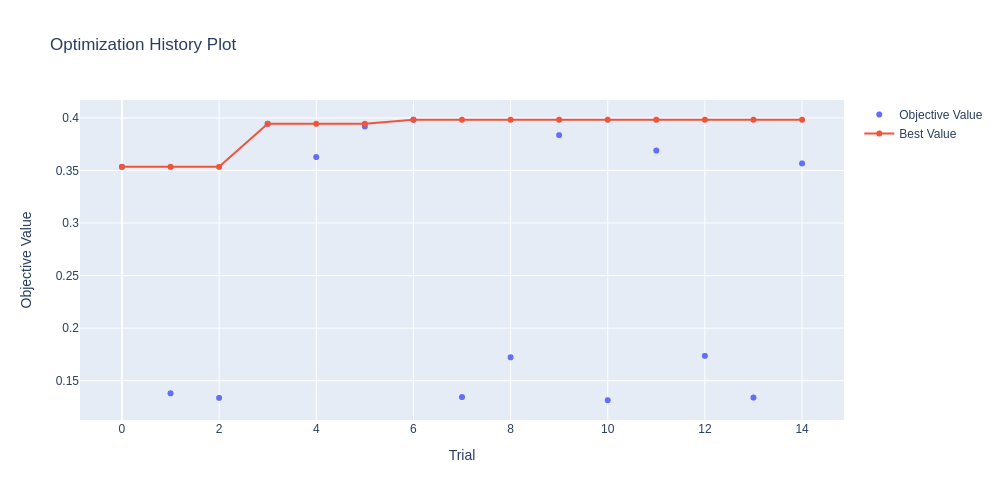

In [48]:
plot_hpo(optuna.visualization.plot_optimization_history(study))


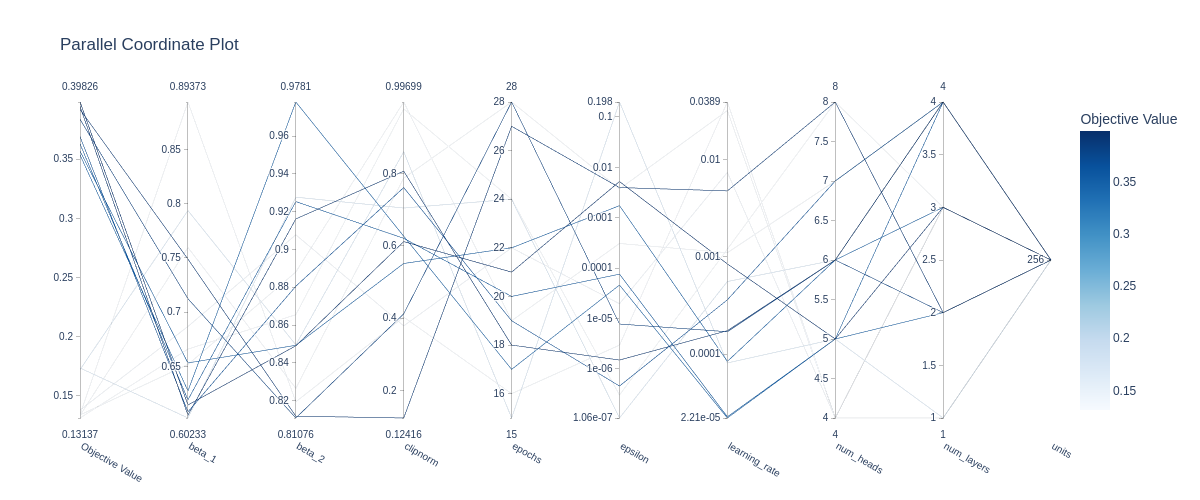

In [49]:
plot_hpo(optuna.visualization.plot_parallel_coordinate(study), height=500, width=1200)



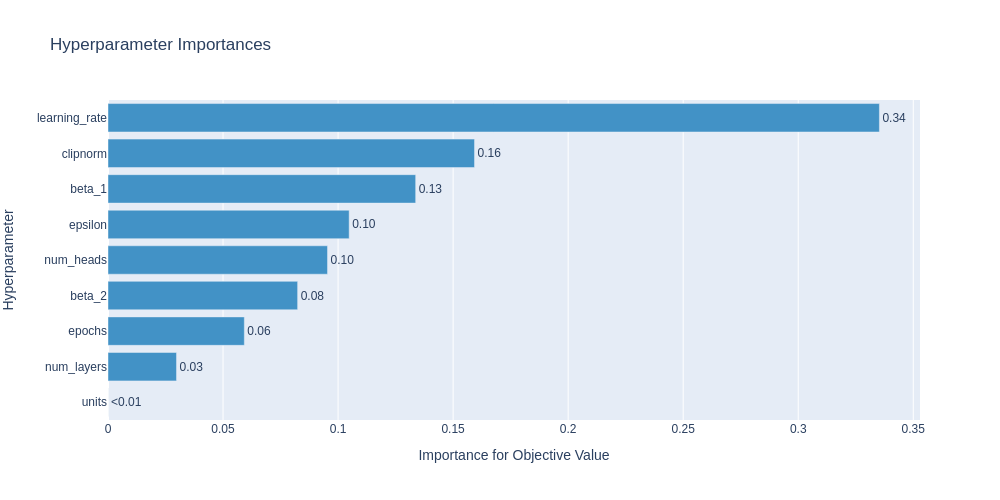

In [50]:
plot_hpo(optuna.visualization.plot_param_importances(study))



### Retrain with Best Hyperparameters

In [64]:
trainer = Trainer(
    train_ds=train_ds,
    test_ds=test_ds,
    feature_extractor=mobilenetv3_large,
    tokenizer=tokenizer,
    output_layer=output_layer,
    # Use best parameters
    hyperparameters=study.best_params,
    steps_per_epoch=np.ceil(len(train_raw) / batch_size),
    validation_steps=np.ceil(len(test_raw) / batch_size),
    patience=5,
    min_delta=1e-3,
    restore_best_model=True
)

model, early_stopping = trainer.fit()

Epoch 1/21
188/188 [==============================] - 72s 235ms/step - loss: 4.5640 - masked_acc: 0.2563 - val_loss: 4.1564 - val_masked_acc: 0.2885
Epoch 2/21
188/188 [==============================] - 22s 116ms/step - loss: 4.0417 - masked_acc: 0.3168 - val_loss: 3.8851 - val_masked_acc: 0.3170
Epoch 3/21
188/188 [==============================] - 21s 114ms/step - loss: 3.8025 - masked_acc: 0.3414 - val_loss: 3.7312 - val_masked_acc: 0.3366
Epoch 4/21
188/188 [==============================] - 22s 115ms/step - loss: 3.7048 - masked_acc: 0.3501 - val_loss: 3.5768 - val_masked_acc: 0.3429
Epoch 5/21
188/188 [==============================] - 22s 119ms/step - loss: 3.6417 - masked_acc: 0.3530 - val_loss: 3.4657 - val_masked_acc: 0.3649
Epoch 6/21
188/188 [==============================] - 21s 112ms/step - loss: 3.4414 - masked_acc: 0.3754 - val_loss: 3.4870 - val_masked_acc: 0.3615
Epoch 7/21
188/188 [==============================] - 21s 111ms/step - loss: 3.3919 - masked_acc: 0.3782 -

## Inference

Finally, we can use the function below to sample images to generate captions:

In [66]:
def sample_images(path: str, image_size: Tuple[int, int, int], num_samples: int = 10) -> List[tf.Tensor]:
    """
    This function samples a given number of images from a folder, loads them in, and resizes them.

    Parameters
    ----------
    path: str
        The path to the folder containing the images.
    image_size: Tuple[int, int, int]
        The size to which the images should be resized.
    num_samples: int, optional
        The number of images to sample. Default is 10.

    Returns
    -------
    list of tf.Tensor
        A list of the loaded and resized images as tf.Tensors.
    """
    images = os.listdir(path)
    sampled_images = random.sample(images, num_samples)
    return [load_image(os.path.join(path, image), image_size) for image in sampled_images]

In [68]:
image_folder = os.path.join(os.getcwd(), 'flickr8k/Flicker8k_Dataset')

images = sample_images(image_folder, image_size, num_samples=10)

Generate captions with attention plots:

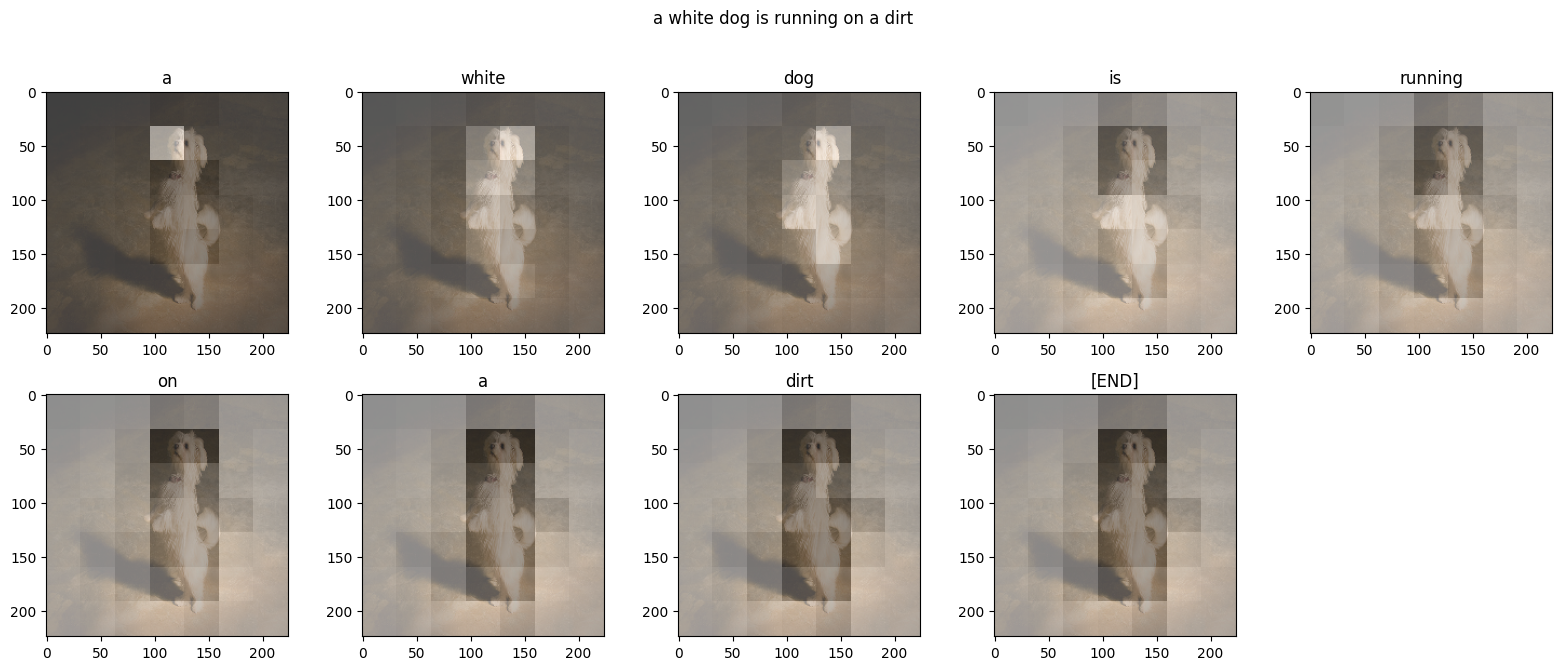

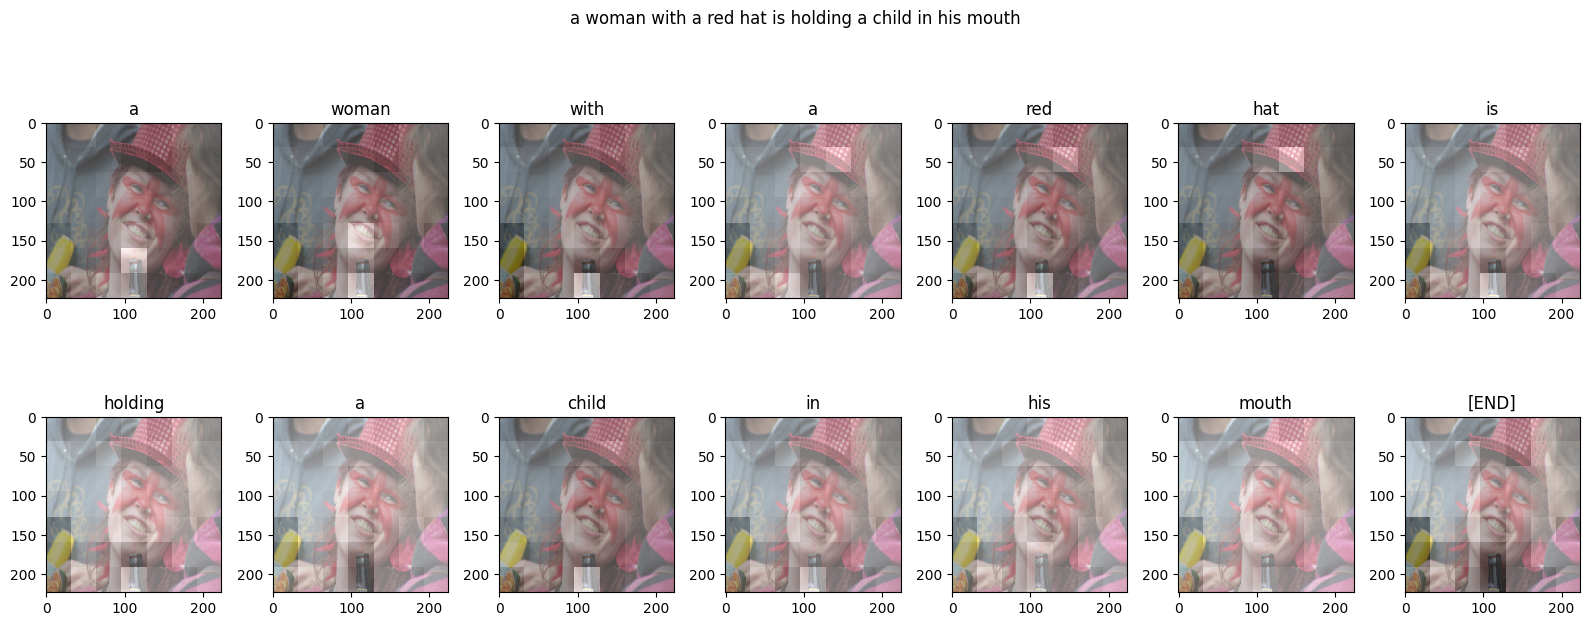

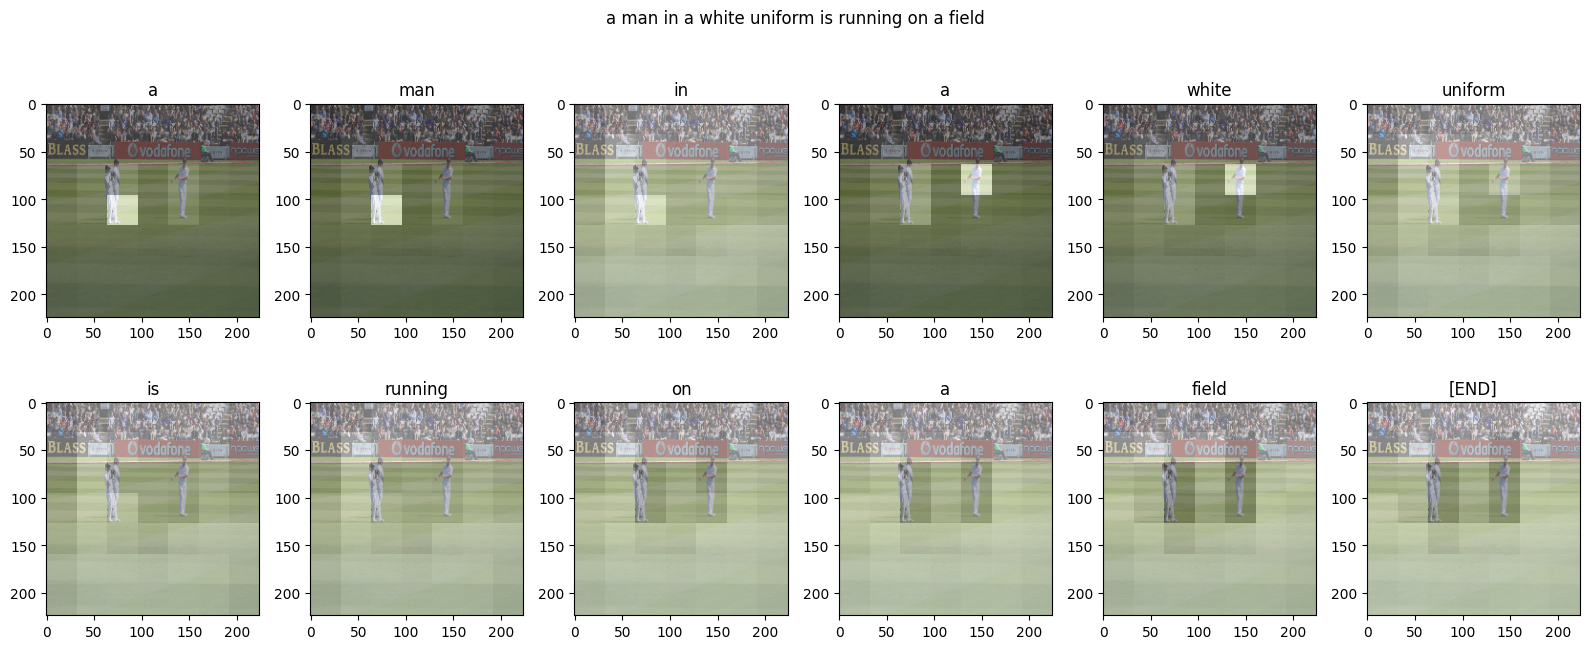

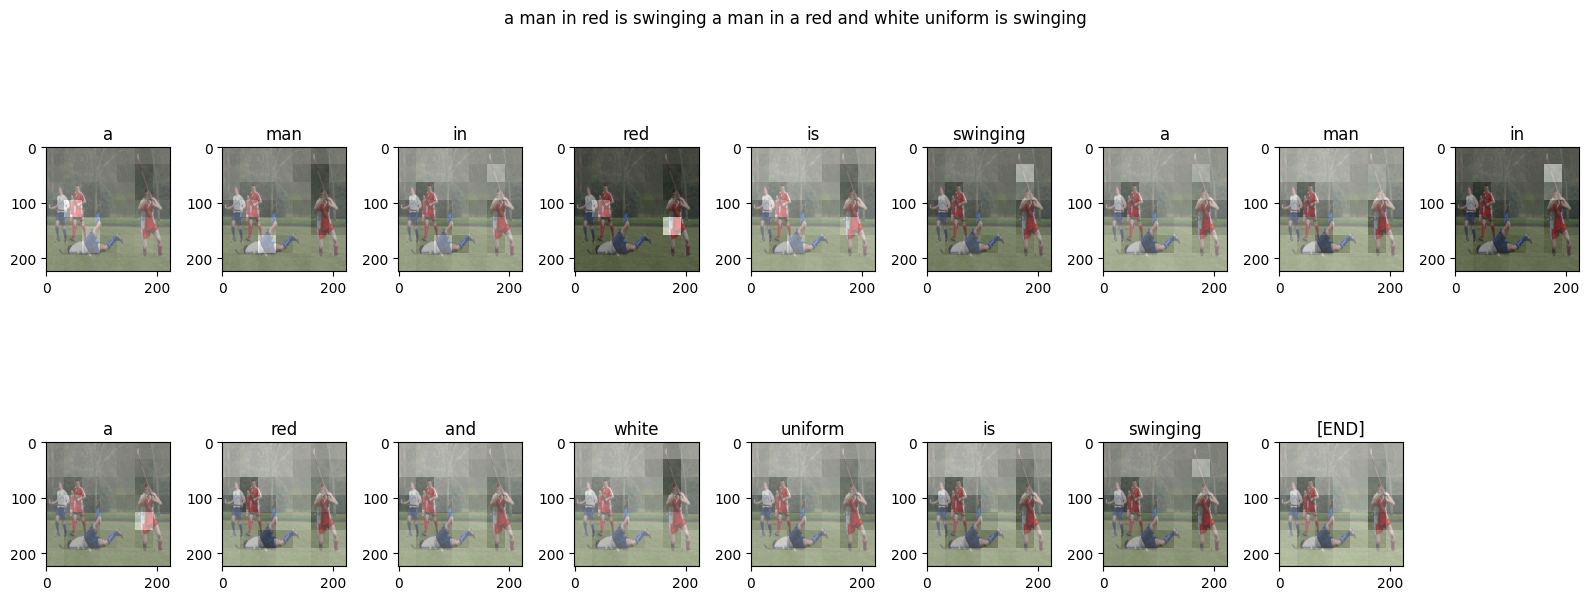

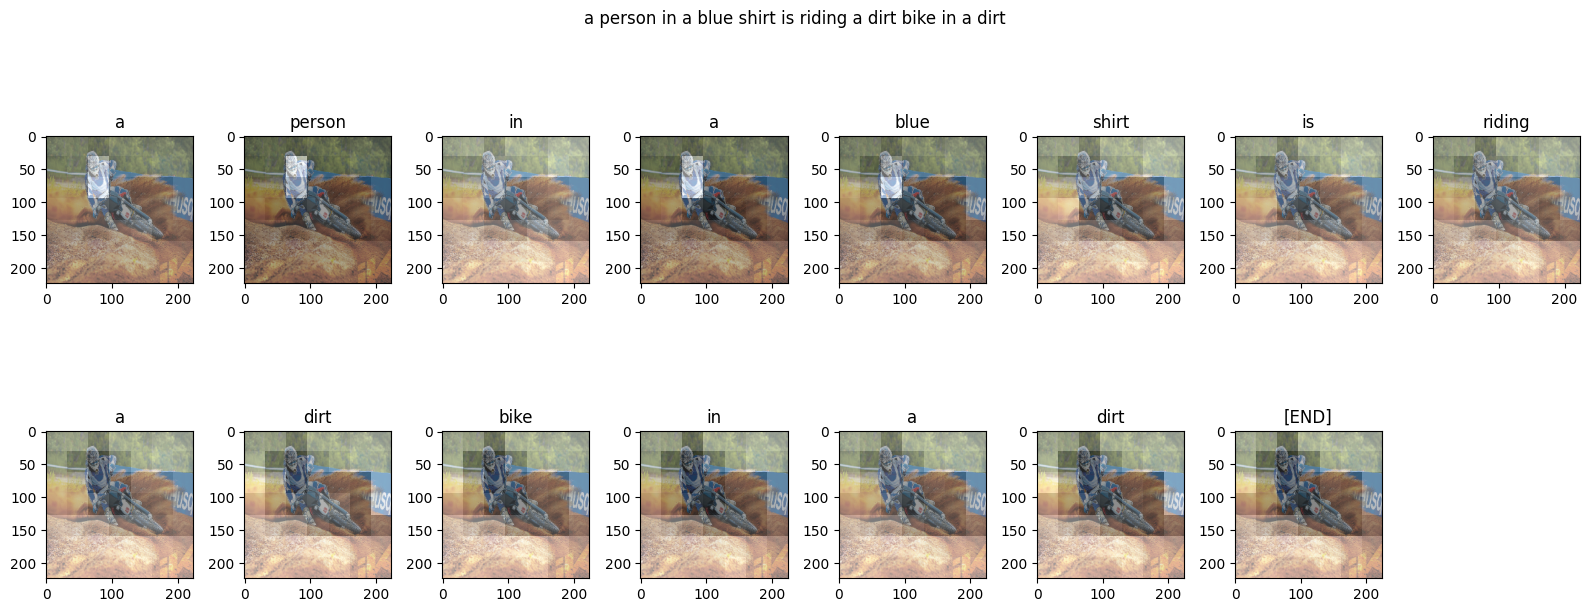

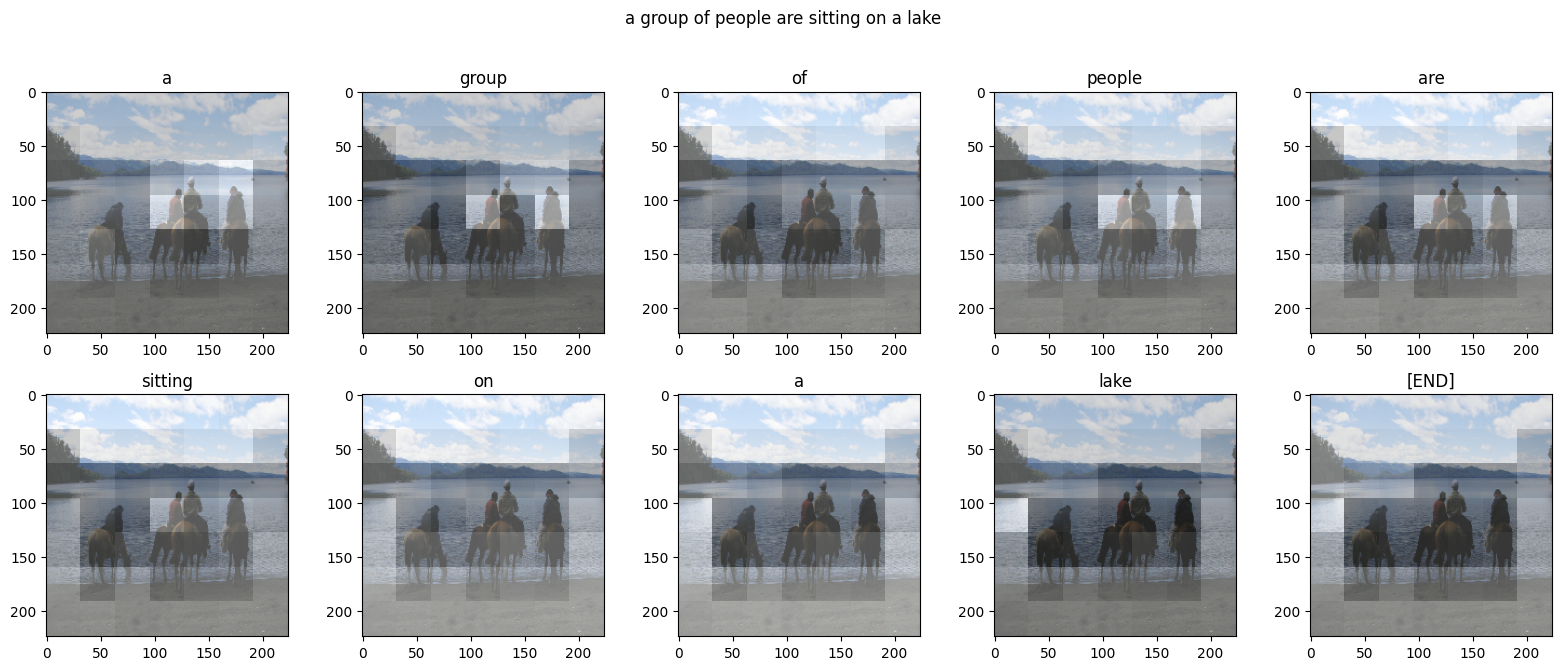

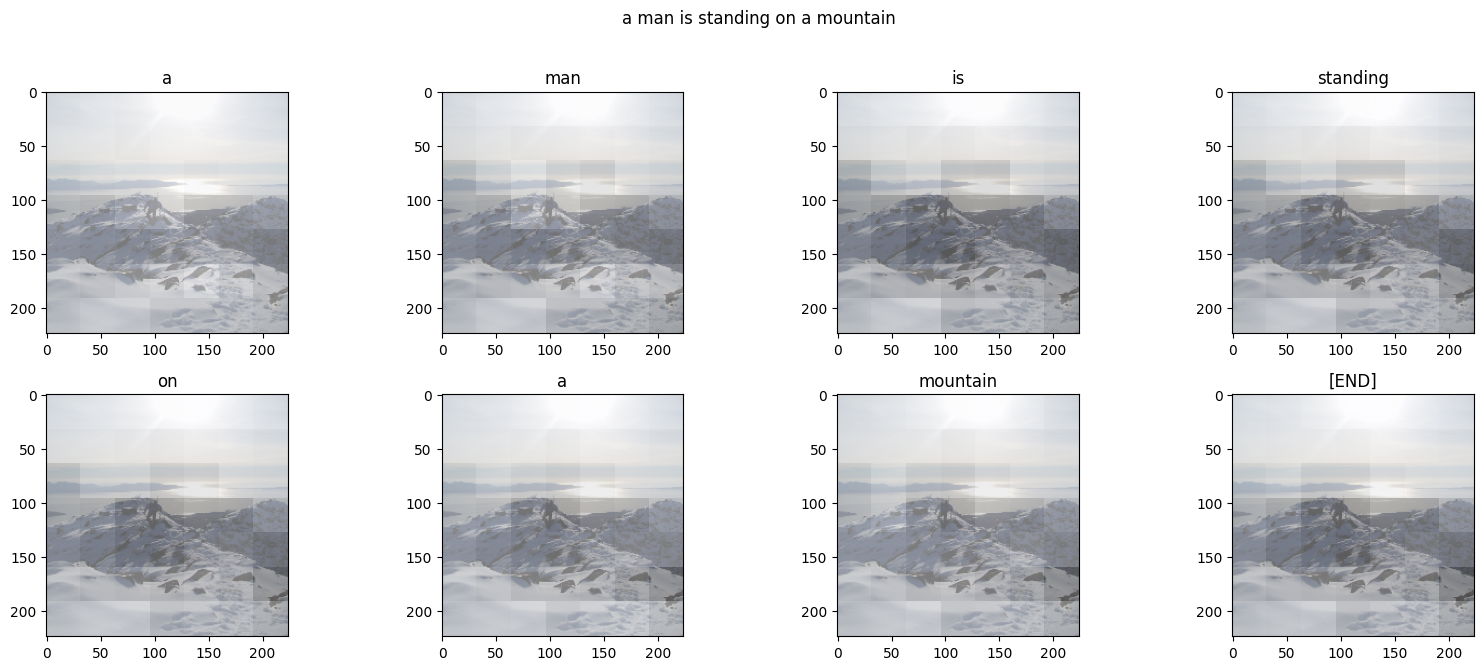

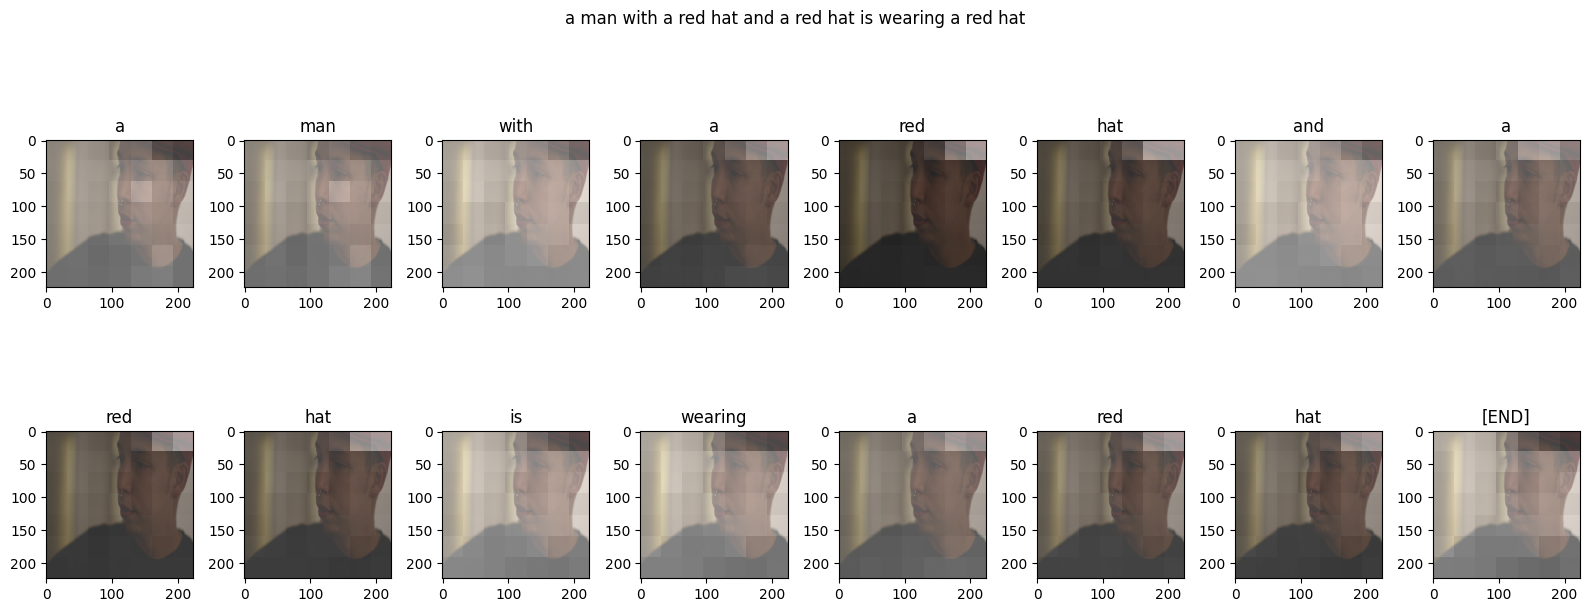

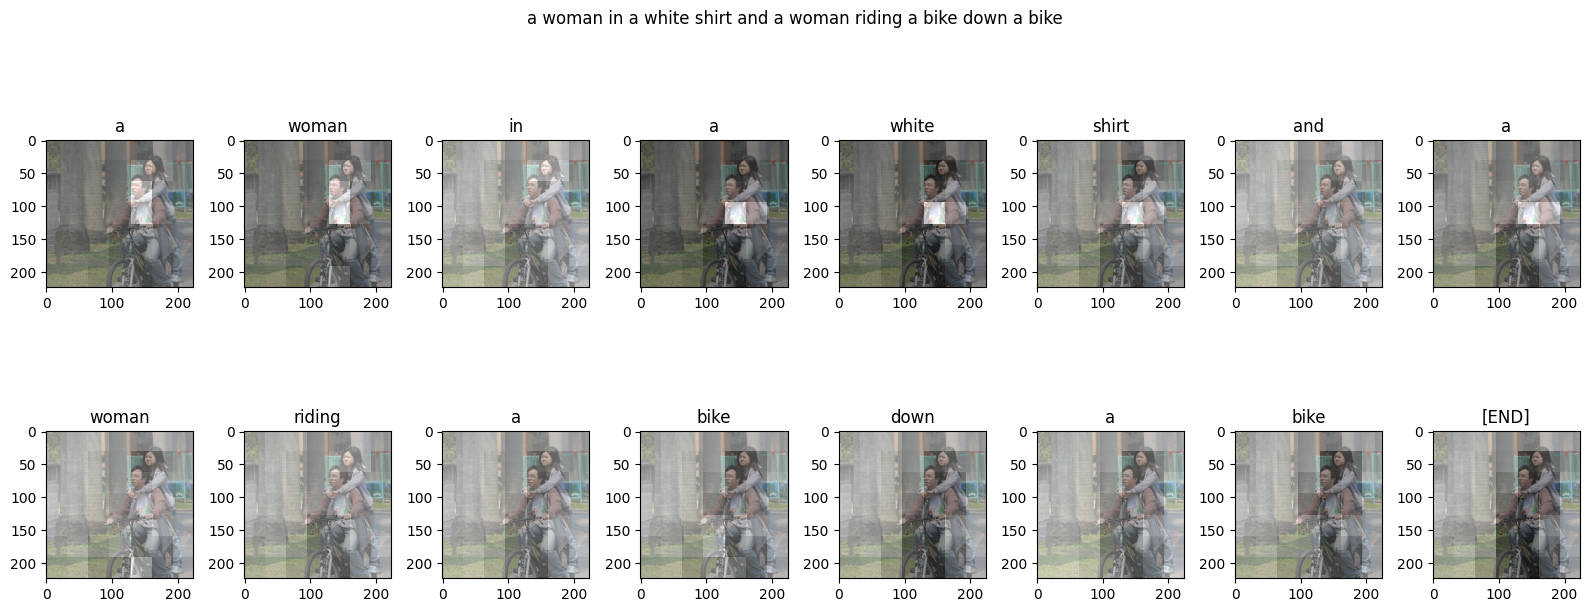

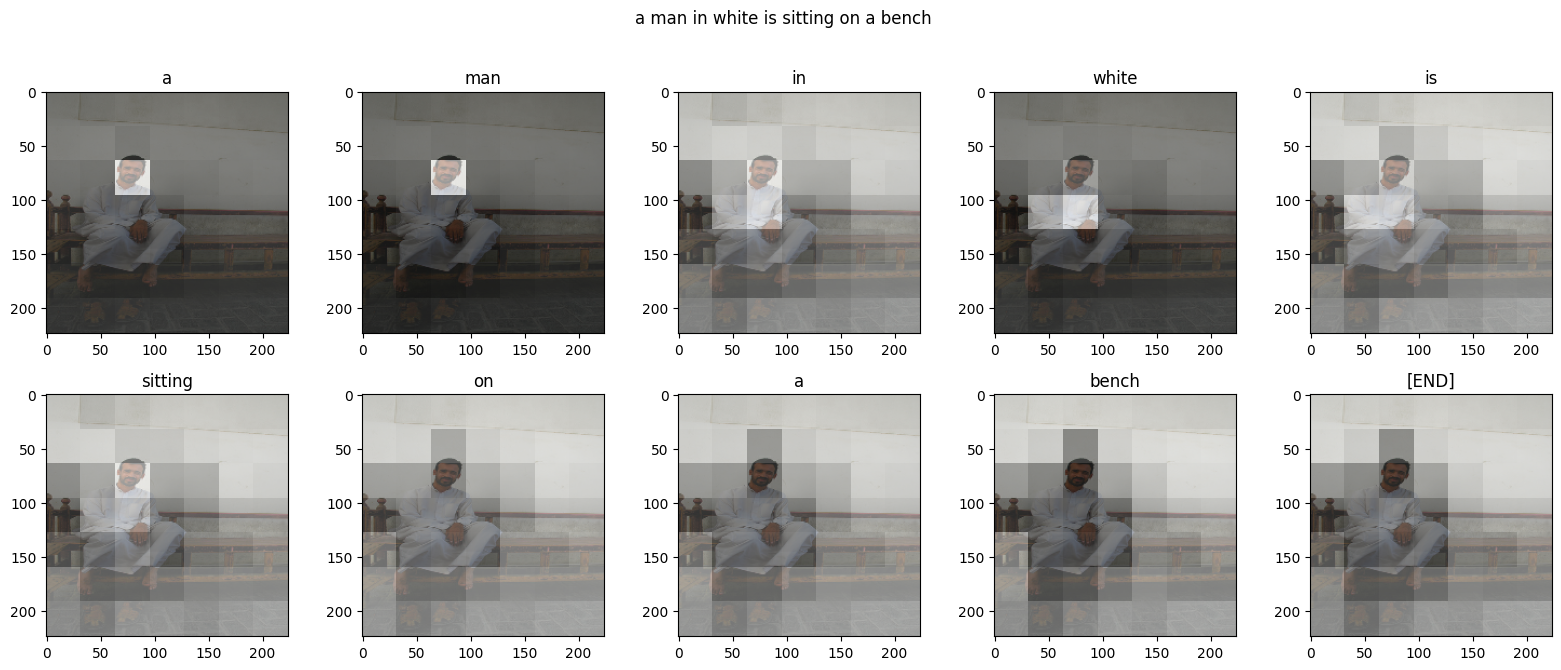

In [74]:
for image in images:
    model.generate_caption_and_plot(image, temperature=0.0)
    time.sleep(1)